In [3]:
pip install pandas numpy matplotlib seaborn psutil

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from resource_metrics_and_visualizations import (
    add_metrics_to_predictor,
    ResourceMetrics
)
from paper_visualizations import PaperVisualizations
from integration_example import run_tte_prediction_with_metrics

2025-05-09 17:58:53.447878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 17:58:53.447942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 17:58:53.466347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 17:58:53.503931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-09 17:59:01.247587: W tensorflow/compiler/tf2

Analysis started with configuration saved to ./results/20250509_175914/config.json
Running on CPU (GPU disabled in config)

--- LOADING DATA ---
Loaded data with 39716 rows and 500 vehicles

--- CLEANING DATA ---
Data cleaned: 39716 rows remaining with 105 features

--- ENGINEERING FEATURES ---

Sample counts per variability level:
variability
high      13504
low       13106
medium    13106
Name: count, dtype: int64
Feature engineering complete. Total features: 124

--- ANALYZING SCENARIOS ---

Analyzing low variability scenario...
Processing 13106 samples for low variability
Created 8283 sequences for evaluation

Processing fold 1 of 2
Training with 2761 sequences, testing with 2761 sequences
Selected 20 features for Ridge Regression
LSTM input shape: (2761, 10, 124)
Epoch 1/15


2025-05-09 17:59:53.120301: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-09 17:59:53.120340: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: gpu-parallel-dy-gpu-parallel-cr-9
2025-05-09 17:59:53.120347: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: gpu-parallel-dy-gpu-parallel-cr-9
2025-05-09 17:59:53.120468: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.216.1
2025-05-09 17:59:53.120487: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.216.1
2025-05-09 17:59:53.120492: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.216.1


69/69 [==============================] - 2s 7ms/step - loss: 0.1482 - val_loss: 0.0660
Epoch 2/15
69/69 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0739
Epoch 3/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0367 - val_loss: 0.0566
Epoch 4/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0273 - val_loss: 0.0411
Epoch 5/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0229 - val_loss: 0.0368
Epoch 6/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0193 - val_loss: 0.0343
Epoch 7/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0269
Epoch 8/15
69/69 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0276
Epoch 9/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0235
Epoch 10/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0142 - val_loss: 0.0233
Epoch 11/15
69/69 [===========

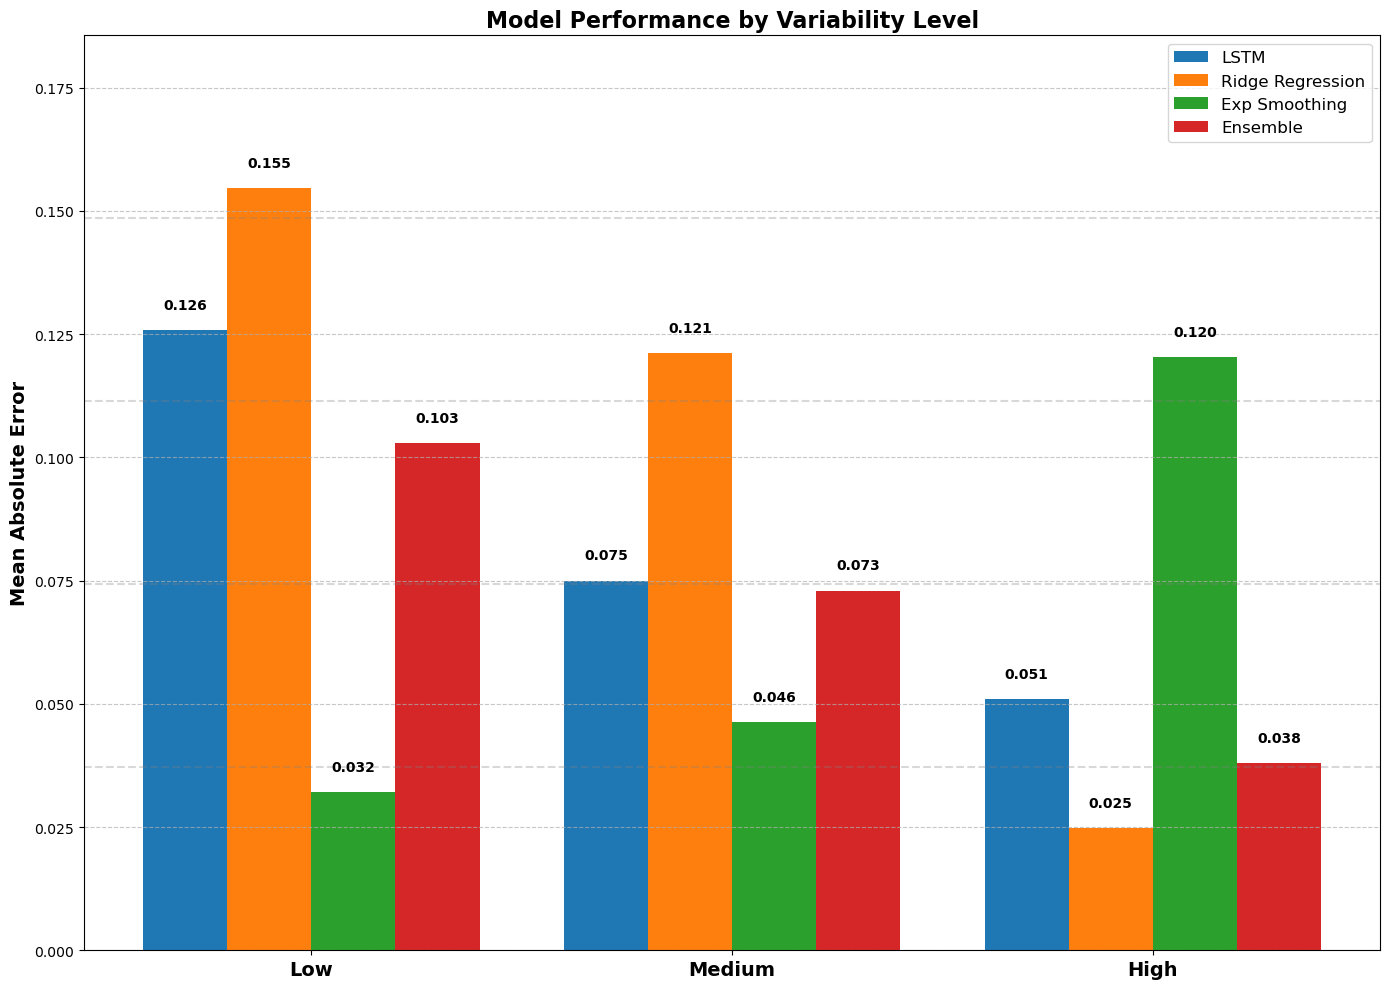

Zoomed MAE comparison plot saved to ./results/20250509_175914/mae_comparison_zoomed_20250509_175914.png


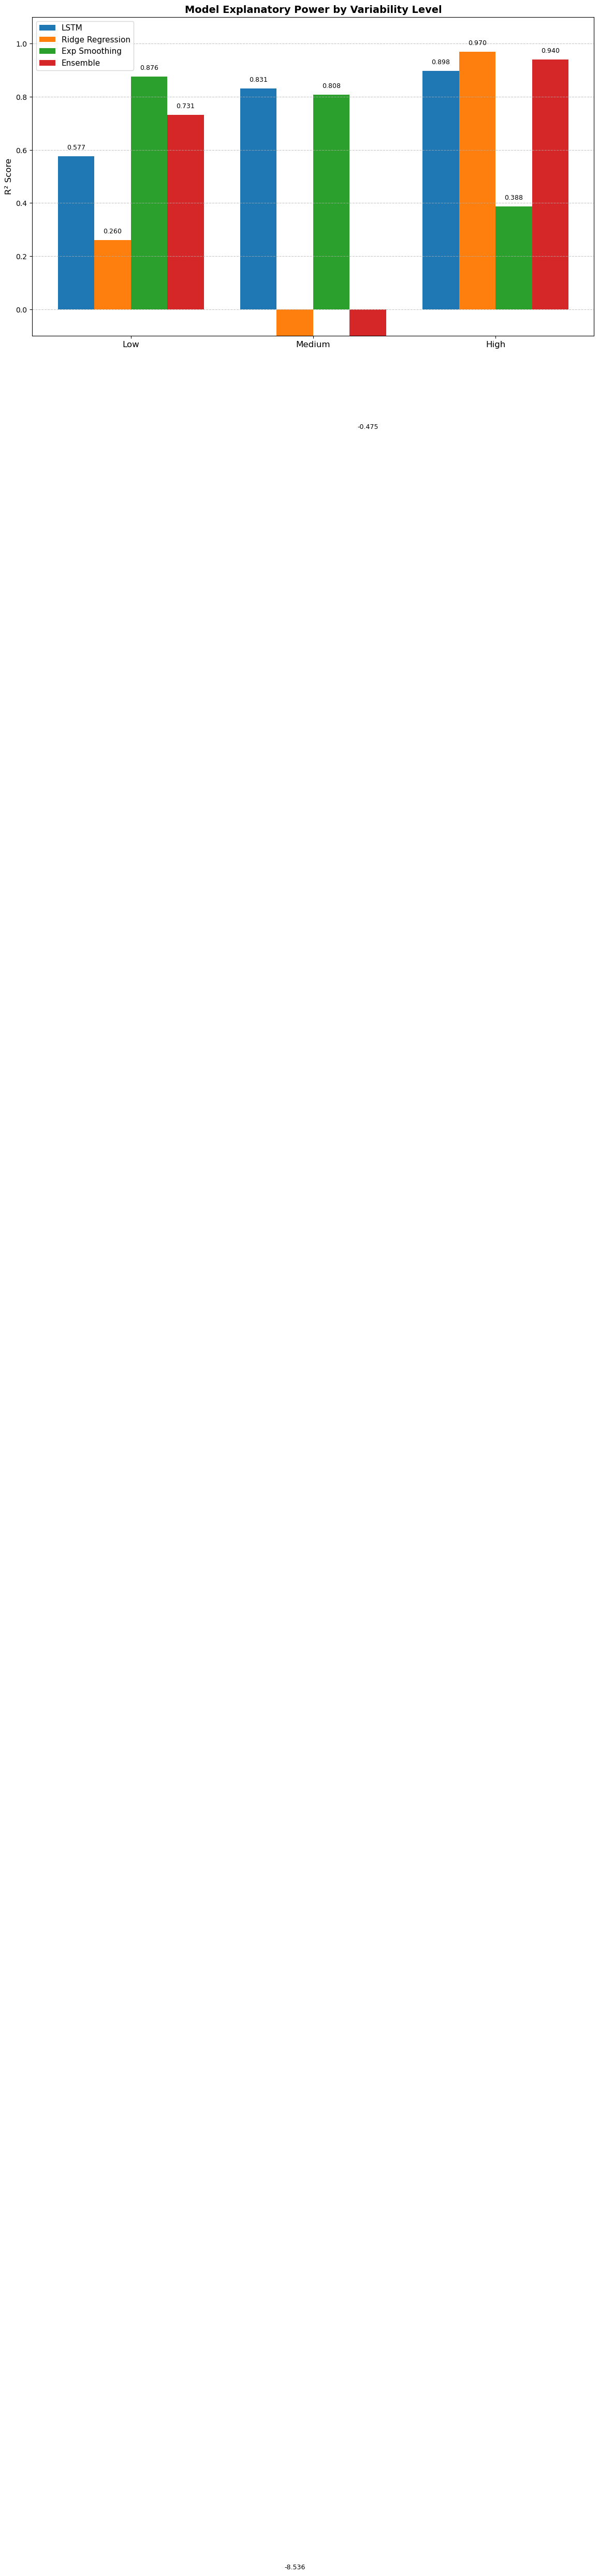

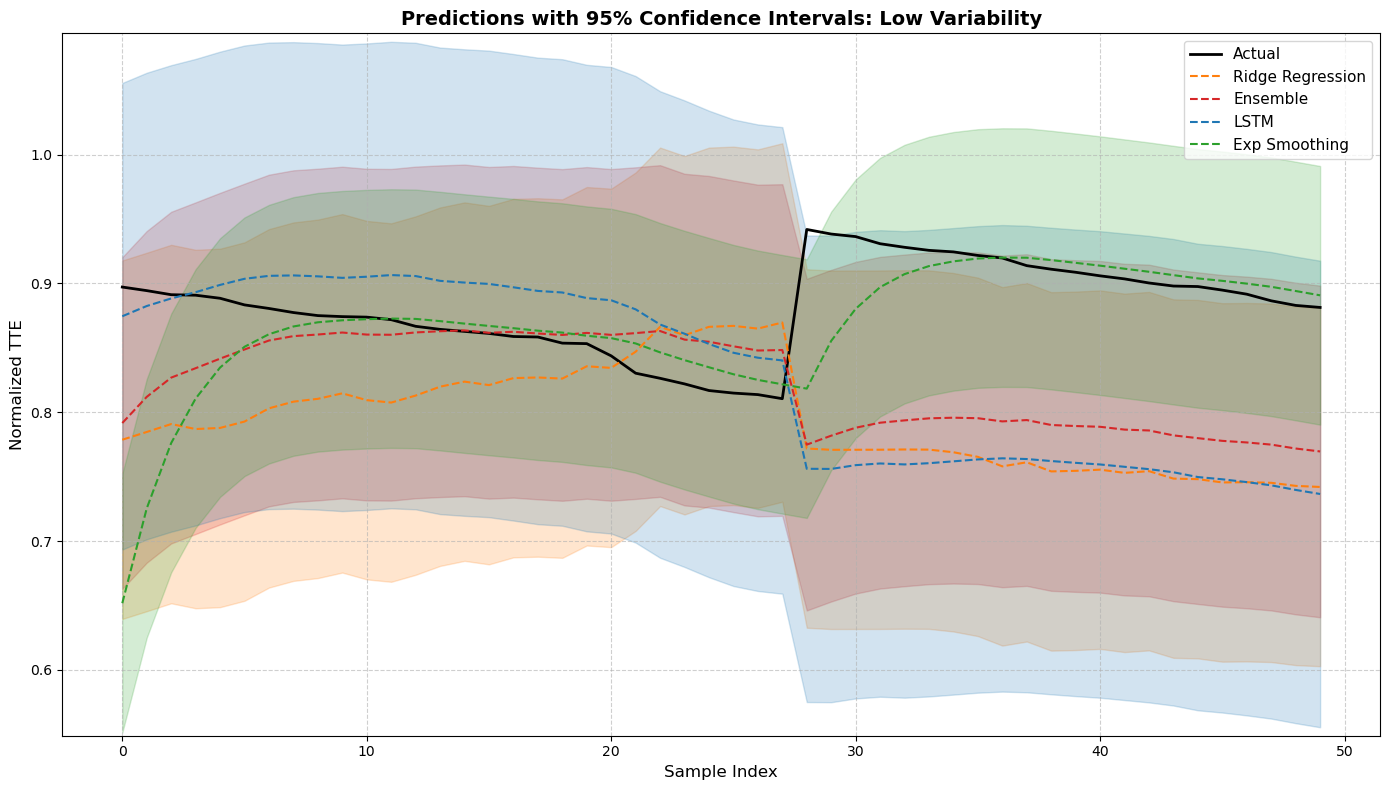

No prediction data available for error plot in low scenario


<Figure size 1400x800 with 0 Axes>

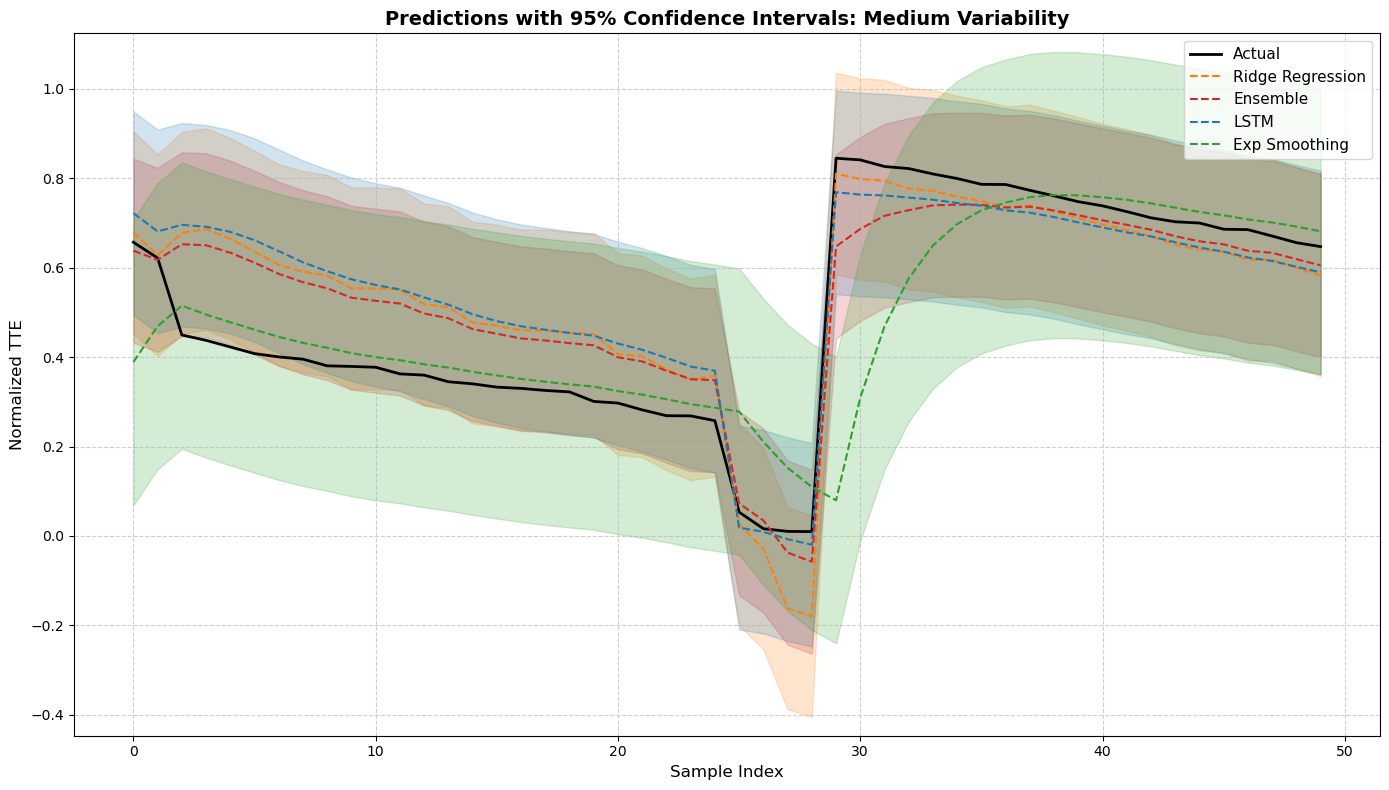

No prediction data available for error plot in medium scenario


<Figure size 1400x800 with 0 Axes>

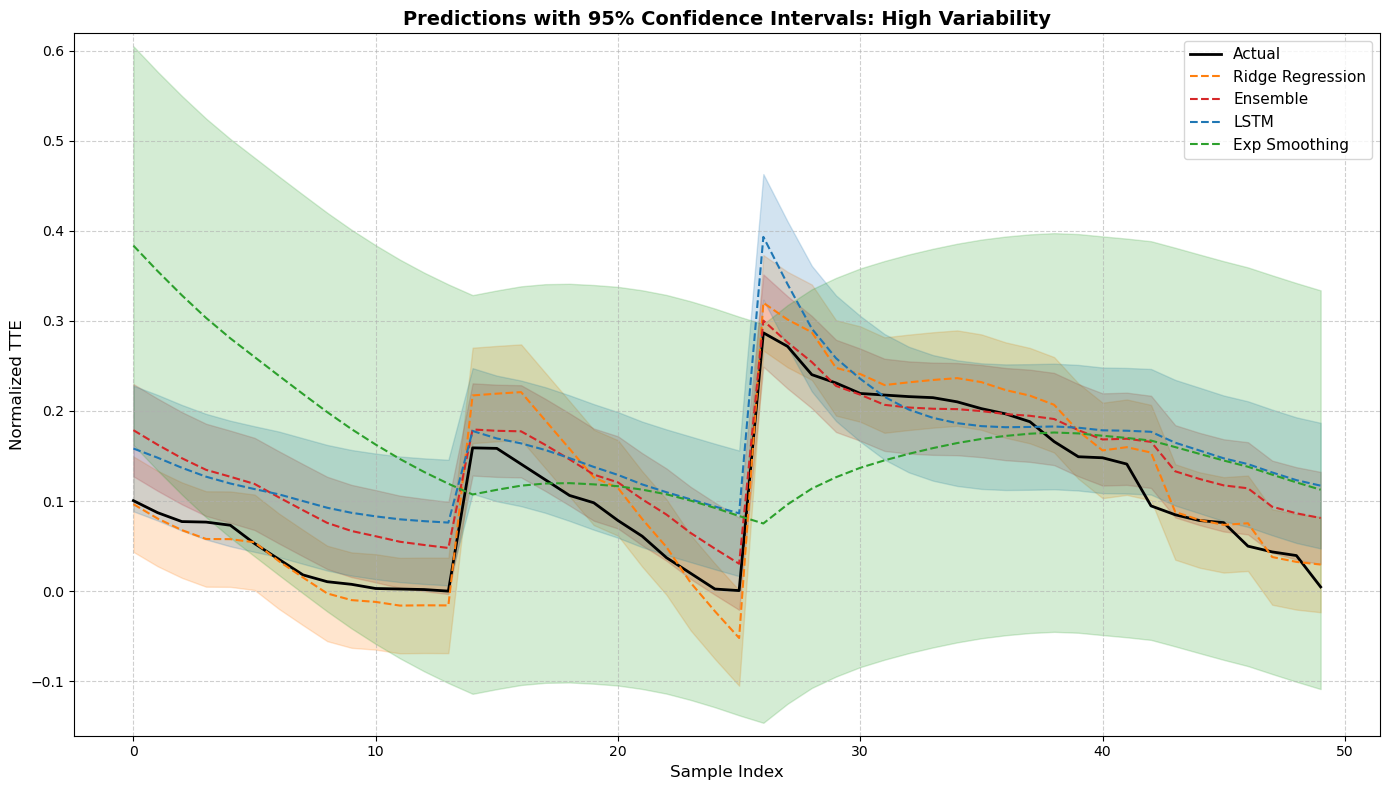

No prediction data available for error plot in high scenario


<Figure size 1400x800 with 0 Axes>

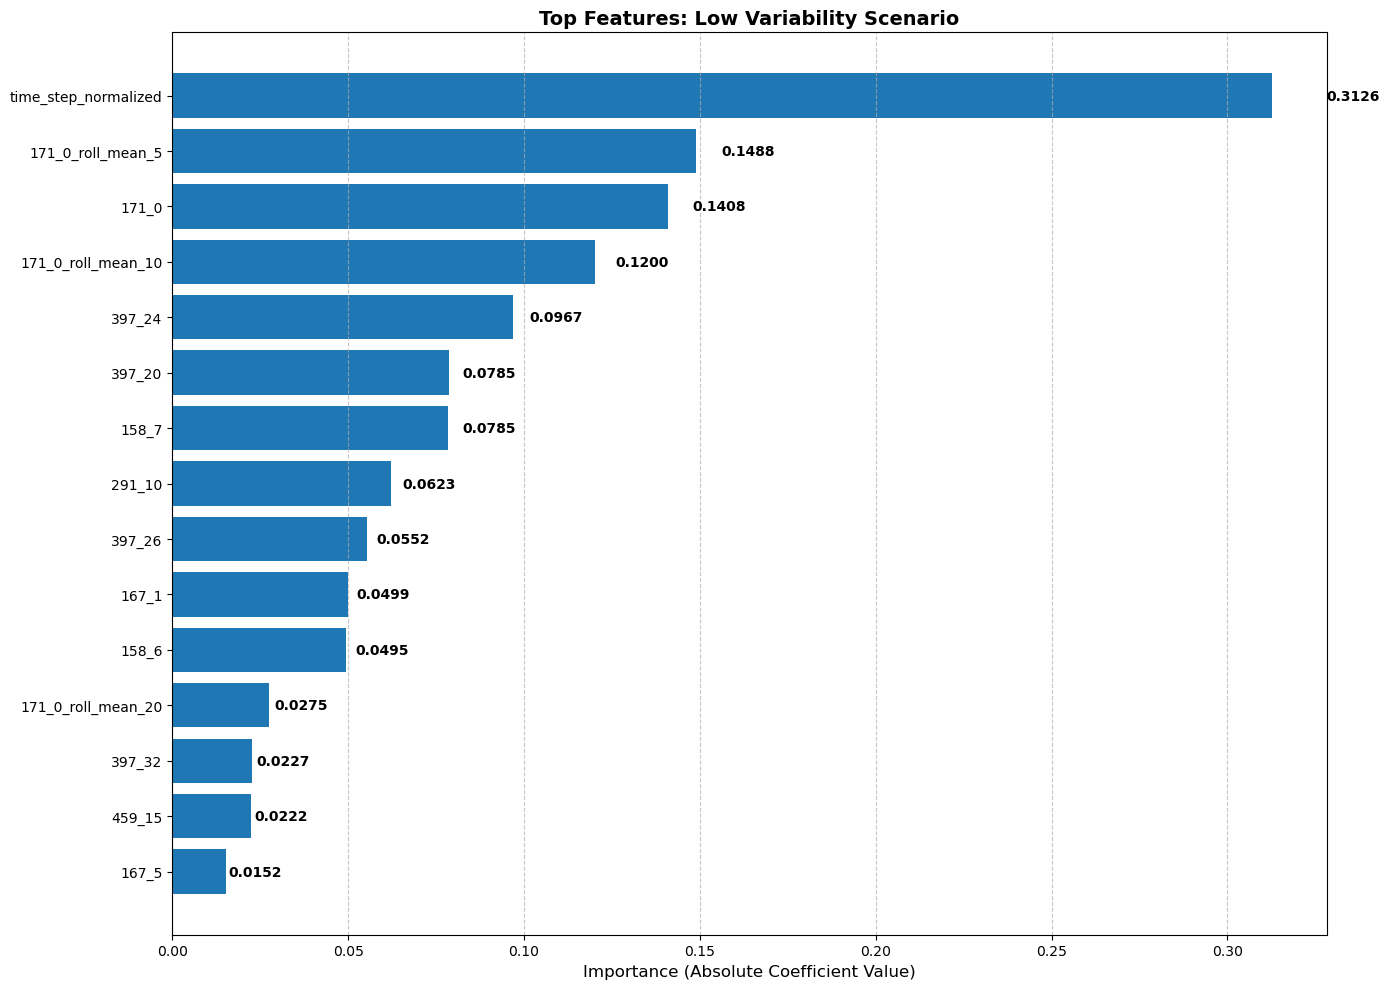

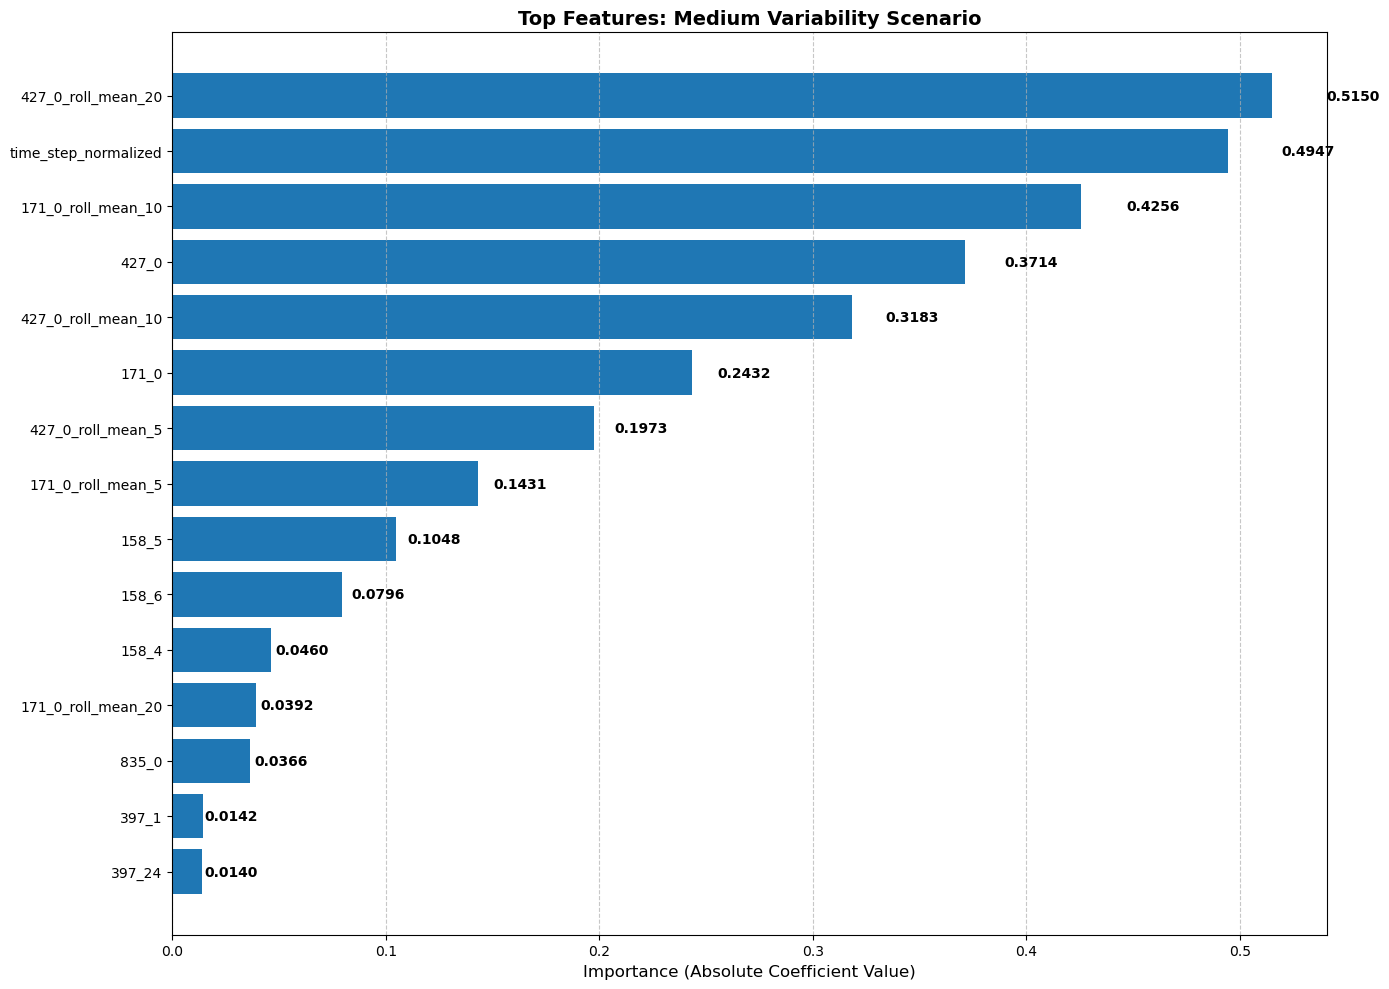

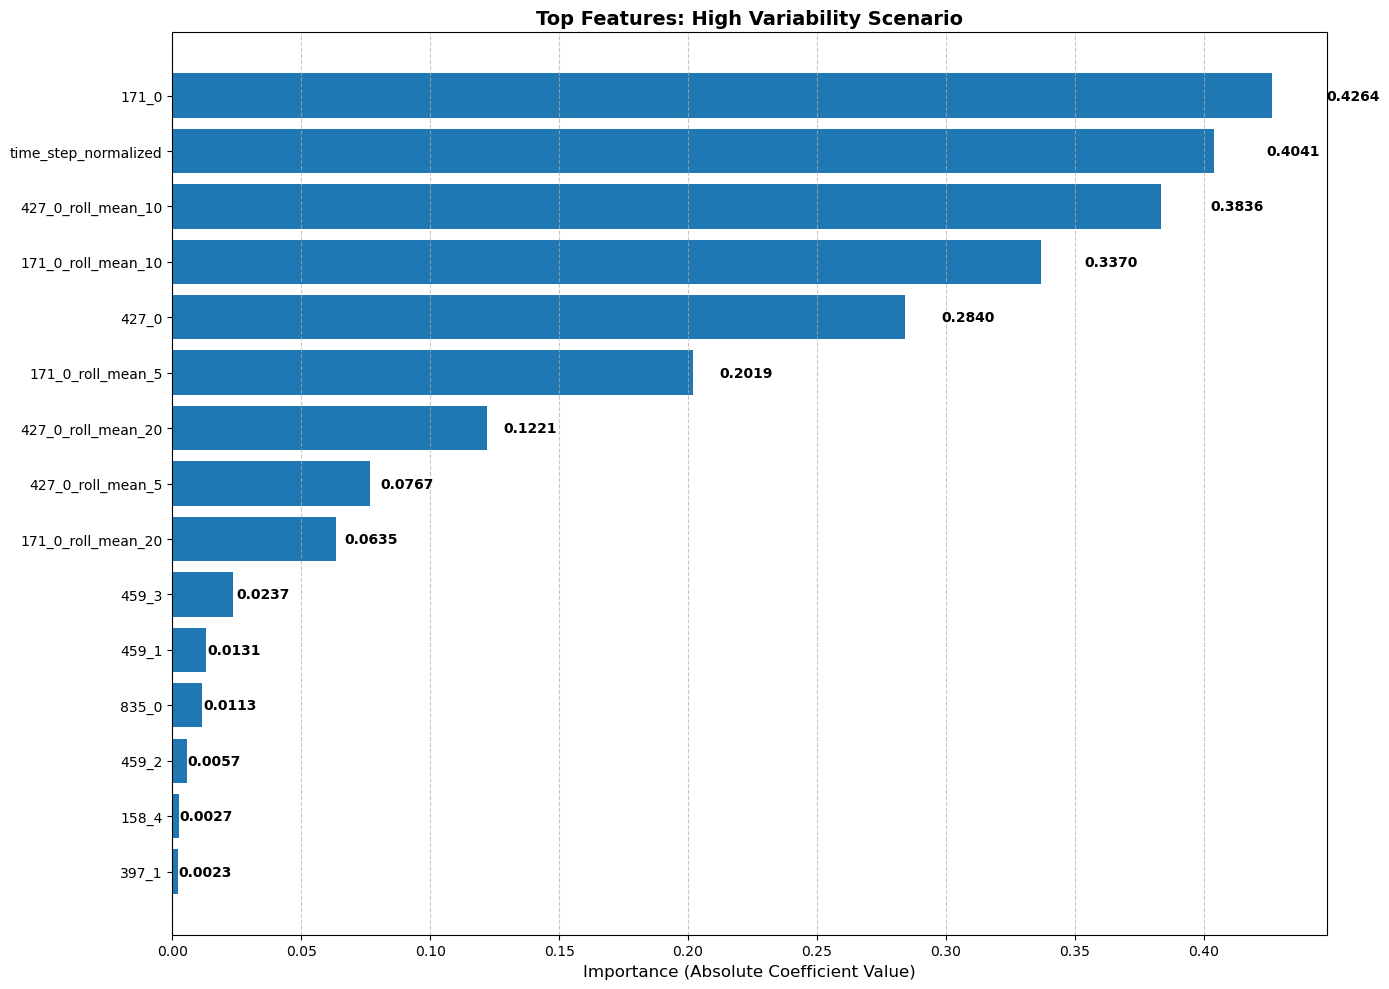


Analysis complete. Results saved to ./results/20250509_175914


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import os
from datetime import datetime
import warnings
import traceback
warnings.filterwarnings('ignore')

class Config:
    def __init__(self, config_path=None):
        if config_path and os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
        else:
            config = {
                'vehicle_subset_size': 500,
                'n_steps': 10,
                'n_epochs': 15,
                'batch_size': 32,
                'ridge_alphas': [0.01, 0.1, 1.0, 10.0, 100.0],
                'es_smoothing_levels': [0.1, 0.3, 0.5, 0.7, 0.9],
                'max_na_percentage': 0.3,
                'window_sizes': [5, 10, 20],
                'variability_window': 50,
                'create_plots': True,
                'save_models': True,
                'skip_lstm': False,  # Enable LSTM by default
                'models_dir': './models',
                'results_dir': './results',
                'use_gpu': False,
                'feature_selection': {
                    'enabled': True,
                    'k': 20
                },
                'sequence_limit': 3000
            }
        self.__dict__.update(config)
        if self.save_models and not os.path.exists(self.models_dir):
            os.makedirs(self.models_dir)
        if not os.path.exists(self.results_dir):
            os.makedirs(self.results_dir)

class TTEPredictor:
    def __init__(self, config=None):
        self.config = config if config else Config()
        self.data = None
        self.feature_cols = None
        self.scenario_results = {}
        self.scaler_X_lstm = MinMaxScaler()
        self.scaler_X_lr = RobustScaler()
        self.scaler_y = MinMaxScaler()
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        if not self.config.use_gpu:
            print("Running on CPU (GPU disabled in config)")
            os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

    def load_data(self, operational_path, tte_path):
        print("\n--- LOADING DATA ---")
        operational_df = pd.read_csv(operational_path)
        tte_df = pd.read_csv(tte_path)
        vehicle_subset = operational_df['vehicle_id'].unique()[:self.config.vehicle_subset_size]
        operational_df = operational_df[operational_df['vehicle_id'].isin(vehicle_subset)]
        tte_df = tte_df[tte_df['vehicle_id'].isin(vehicle_subset)]
        data = pd.merge(
            operational_df,
            tte_df[['vehicle_id', 'length_of_study_time_step']].rename(columns={'length_of_study_time_step': 'max_time_step'}),
            on='vehicle_id',
            how='left'
        )
        data['tte'] = data['max_time_step'] - data['time_step']
        self.data = data
        print(f"Loaded data with {len(self.data)} rows and {self.data['vehicle_id'].nunique()} vehicles")
        return self

    def clean_data(self):
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        print("\n--- CLEANING DATA ---")
        feature_cols = [col for col in self.data.columns if col not in ['vehicle_id', 'time_step', 'max_time_step', 'tte', 'rolling_std', 'variability']]
        self.data[feature_cols] = self._improved_clean_dataset(self.data[feature_cols], self.data['vehicle_id'])
        self.data = self.data.dropna(subset=['tte']).reset_index(drop=True)
        self.feature_cols = feature_cols
        print(f"Data cleaned: {len(self.data)} rows remaining with {len(feature_cols)} features")
        return self

    def _improved_clean_dataset(self, df, vehicle_ids, max_na_percentage=None):
        if max_na_percentage is None:
            max_na_percentage = self.config.max_na_percentage
        df = df.loc[:, df.isnull().mean() < max_na_percentage]
        df = df.replace([np.inf, -np.inf], np.nan)
        df_work = df.copy()
        df_work['vehicle_id'] = vehicle_ids.values
        result_df = pd.DataFrame(index=df.index, columns=df.columns)
        for vehicle in df_work['vehicle_id'].unique():
            vehicle_idx = df_work[df_work['vehicle_id'] == vehicle].index
            for col in df.columns:
                series = df_work.loc[vehicle_idx, col]
                filled = series.ffill().bfill()
                result_df.loc[vehicle_idx, col] = filled
        for vehicle in df_work['vehicle_id'].unique():
            vehicle_idx = df_work[df_work['vehicle_id'] == vehicle].index
            for col in df.columns:
                if result_df.loc[vehicle_idx, col].isnull().any():
                    median = df_work.loc[vehicle_idx, col].median()
                    if pd.isna(median):
                        result_df.loc[vehicle_idx, col] = result_df.loc[vehicle_idx, col].fillna(0)
                    else:
                        result_df.loc[vehicle_idx, col] = result_df.loc[vehicle_idx, col].fillna(median)
        for col in df.columns:
            if result_df[col].isnull().any():
                global_median = df[col].median()
                if pd.isna(global_median):
                    result_df[col] = result_df[col].fillna(0)
                else:
                    result_df[col] = result_df[col].fillna(global_median)
        return result_df

    def engineer_features(self):
        if self.data is None or self.feature_cols is None:
            raise ValueError("No data or features available. Call load_data() and clean_data() first.")
        print("\n--- ENGINEERING FEATURES ---")
        self.data['time_step_normalized'] = self.data['time_step'] / self.data.groupby('vehicle_id')['max_time_step'].transform('max')
        feature_subset = self.feature_cols[:3]
        window_sizes = self.config.window_sizes
        for feature in feature_subset:
            for window in window_sizes:
                new_mean_col = f'{feature}_roll_mean_{window}'
                new_std_col = f'{feature}_roll_std_{window}'
                self.data[new_mean_col] = np.nan
                self.data[new_std_col] = np.nan
                for vehicle in self.data['vehicle_id'].unique():
                    vehicle_mask = self.data['vehicle_id'] == vehicle
                    vehicle_data = self.data.loc[vehicle_mask, feature]
                    roll_mean = vehicle_data.rolling(window=window, min_periods=1).mean()
                    self.data.loc[vehicle_mask, new_mean_col] = roll_mean
                    roll_std = vehicle_data.rolling(window=window, min_periods=1).std()
                    self.data.loc[vehicle_mask, new_std_col] = roll_std.fillna(0)
        window_size = self.config.variability_window
        self.data['rolling_std'] = np.nan
        for vehicle in self.data['vehicle_id'].unique():
            vehicle_mask = self.data['vehicle_id'] == vehicle
            vehicle_data = self.data.loc[vehicle_mask, 'tte']
            if len(vehicle_data) >= 10:
                roll_std = vehicle_data.rolling(window=window_size, min_periods=10).std()
                roll_std = roll_std.fillna(method='ffill').fillna(0)
                self.data.loc[vehicle_mask, 'rolling_std'] = roll_std
            else:
                self.data.loc[vehicle_mask, 'rolling_std'] = 0
        low_thresh = self.data['rolling_std'].quantile(0.33)
        high_thresh = self.data['rolling_std'].quantile(0.66)
        self.data['variability'] = 'medium'
        self.data.loc[self.data['rolling_std'] <= low_thresh, 'variability'] = 'low'
        self.data.loc[self.data['rolling_std'] > high_thresh, 'variability'] = 'high'
        self.feature_cols = [col for col in self.data.columns if col not in ['vehicle_id', 'time_step', 'max_time_step', 'tte', 'rolling_std', 'variability']]
        variability_counts = self.data['variability'].value_counts()
        print("\nSample counts per variability level:")
        print(variability_counts)
        if len(variability_counts) < 3:
            print("Warning: Not all variability levels have data. Recalculating thresholds...")
            sorted_std = self.data['rolling_std'].sort_values()
            n = len(sorted_std)
            low_thresh = sorted_std.iloc[n//3]
            high_thresh = sorted_std.iloc[2*n//3]
            self.data['variability'] = 'medium'
            self.data.loc[self.data['rolling_std'] <= low_thresh, 'variability'] = 'low'
            self.data.loc[self.data['rolling_std'] > high_thresh, 'variability'] = 'high'
            print("Updated variability distribution:")
            print(self.data['variability'].value_counts())
        print(f"Feature engineering complete. Total features: {len(self.feature_cols)}")
        return self

    def build_improved_lstm(self, input_shape):
        units = 16
        dropout_rate = 0.2
        try:
            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=input_shape),
                tf.keras.layers.LSTM(units, activation='tanh',
                                    recurrent_activation='sigmoid',
                                    dropout=dropout_rate,
                                    recurrent_dropout=dropout_rate),
                tf.keras.layers.Dense(8, activation='relu'),
                tf.keras.layers.Dense(1)
            ])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss='mse')
            return model
        except Exception as e:
            print(f"Error building LSTM model: {e}")
            print("Will use mean prediction instead of LSTM")
            traceback.print_exc()
            return None

    def create_sequences_by_vehicle(self, data, feature_cols, n_steps=None):
        if n_steps is None:
            n_steps = self.config.n_steps
        X_lstm_sequences = []
        X_lr_last_points = []
        y_values = []
        global_X = data[feature_cols].values
        global_y = data['tte'].values.reshape(-1, 1)
        self.scaler_X_lstm.fit(global_X)
        self.scaler_X_lr.fit(global_X)
        self.scaler_y.fit(global_y)
        for vehicle_id in data['vehicle_id'].unique():
            vehicle_data = data[data['vehicle_id'] == vehicle_id]
            if len(vehicle_data) <= n_steps:
                continue
            X_vehicle = vehicle_data[feature_cols].values
            y_vehicle = vehicle_data['tte'].values
            X_vehicle_scaled_lstm = self.scaler_X_lstm.transform(X_vehicle)
            X_vehicle_scaled_lr = self.scaler_X_lr.transform(X_vehicle)
            y_vehicle_scaled = self.scaler_y.transform(y_vehicle.reshape(-1, 1)).flatten()
            for i in range(len(vehicle_data) - n_steps):
                X_lstm_sequences.append(X_vehicle_scaled_lstm[i:i+n_steps])
                X_lr_last_points.append(X_vehicle_scaled_lr[i+n_steps-1])
                y_values.append(y_vehicle_scaled[i+n_steps])
        X_lstm = np.array(X_lstm_sequences)
        X_lr_last = np.array(X_lr_last_points)
        y = np.array(y_values)
        return X_lstm, X_lr_last, y

    def analyze_scenarios(self, variability_levels=None):
        """Analyze each variability scenario."""
        if variability_levels is None:
            variability_levels = ['low', 'medium', 'high']
            
        print("\n--- ANALYZING SCENARIOS ---")
        
        # Now analyze each scenario with better error handling
        for var_level in variability_levels:
            try:
                print(f"\nAnalyzing {var_level} variability scenario...")
                scenario_data = self.data[self.data['variability'] == var_level]
                
                # Check if we have enough data
                if len(scenario_data) < 100:
                    print(f"Not enough data for {var_level} variability (only {len(scenario_data)} samples)")
                    continue
                    
                print(f"Processing {len(scenario_data)} samples for {var_level} variability")
                results = self.evaluate_scenario(scenario_data)
                
                if results:
                    self.scenario_results[var_level] = results
                else:
                    print(f"No results returned for {var_level} variability")
            except Exception as e:
                print(f"Error analyzing {var_level} variability: {e}")
                print(traceback.format_exc())
                continue
        
        return self

    def evaluate_scenario(self, scenario_data, n_steps=None, n_epochs=None):
        if n_steps is None:
            n_steps = self.config.n_steps
        if n_epochs is None:
            n_epochs = self.config.n_epochs
        X_lstm, X_lr_last, y = self.create_sequences_by_vehicle(scenario_data, self.feature_cols, n_steps)
        if len(X_lstm) < 20:
            print(f"Not enough sequences (only {len(X_lstm)}), skipping scenario")
            return None
        print(f"Created {len(X_lstm)} sequences for evaluation")
        tscv = TimeSeriesSplit(n_splits=2)
        all_results = {
            'lstm_mae': [], 'lstm_rmse': [], 'lstm_r2': [], 'lstm_median_ae': [], 'lstm_explained_var': [],
            'lr_mae': [], 'lr_rmse': [], 'lr_r2': [], 'lr_median_ae': [], 'lr_explained_var': [],
            'es_mae': [], 'es_rmse': [], 'es_r2': [], 'es_median_ae': [], 'es_explained_var': [],
            'ensemble_mae': [], 'ensemble_rmse': [], 'ensemble_r2': [], 'ensemble_median_ae': [], 'ensemble_explained_var': [],
            'y_test': None, 'lstm_preds': None, 'lr_preds': None, 'es_preds': None, 'ensemble_preds': None
        }
        feature_importance = None
        fold = 0
        for train_idx, test_idx in tscv.split(X_lstm):
            fold += 1
            print(f"\nProcessing fold {fold} of 2")
            seq_limit = self.config.sequence_limit
            if len(train_idx) > seq_limit:
                print(f"Limiting training sequences from {len(train_idx)} to {seq_limit}")
                np.random.seed(42)
                train_idx = np.random.choice(train_idx, seq_limit, replace=False)
            if len(test_idx) > seq_limit:
                print(f"Limiting test sequences from {len(test_idx)} to {seq_limit}")
                test_idx = test_idx[:seq_limit]
            X_lstm_train, X_lstm_test = X_lstm[train_idx], X_lstm[test_idx]
            X_lr_train, X_lr_test = X_lr_last[train_idx], X_lr_last[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            print(f"Training with {len(X_lstm_train)} sequences, testing with {len(X_lstm_test)} sequences")
            selected_features = self.feature_cols
            if self.config.feature_selection['enabled'] and X_lr_train.shape[1] > self.config.feature_selection['k']:
                try:
                    selector = SelectKBest(f_regression, k=self.config.feature_selection['k'])
                    X_lr_train_selected = selector.fit_transform(X_lr_train, y_train)
                    X_lr_test_selected = selector.transform(X_lr_test)
                    selected_features = [self.feature_cols[i] for i in selector.get_support(indices=True)]
                    print(f"Selected {len(selected_features)} features for Ridge Regression")
                except Exception as e:
                    print(f"Feature selection failed: {e}, using all features")
                    X_lr_train_selected = X_lr_train
                    X_lr_test_selected = X_lr_test
            else:
                X_lr_train_selected = X_lr_train
                X_lr_test_selected = X_lr_test
            lstm_preds = np.ones(len(y_test)) * np.mean(y_train)
            lr_preds = np.ones(len(y_test)) * np.mean(y_train)
            es_preds = np.ones(len(y_test)) * np.mean(y_train)
            lstm_success = False
            if not self.config.skip_lstm:
                try:
                    print(f"LSTM input shape: {X_lstm_train.shape}")
                    lstm_model = self.build_improved_lstm((X_lstm_train.shape[1], X_lstm_train.shape[2]))
                    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                    callbacks = [early_stopping]
                    if self.config.save_models:
                        model_path = f"{self.config.models_dir}/lstm_{self.timestamp}_fold{fold}.h5"
                        checkpoint = ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min'
                        )
                        callbacks.append(checkpoint)
                    lstm_model.fit(
                        X_lstm_train, y_train,
                        epochs=n_epochs,
                        batch_size=self.config.batch_size,
                        verbose=1,
                        validation_split=0.2,
                        callbacks=callbacks
                    )
                    lstm_preds = lstm_model.predict(X_lstm_test).flatten()
                    lstm_success = True
                    print("LSTM model training and prediction successful")
                except Exception as e:
                    print(f"LSTM error: {e}")
                    print("Using mean prediction for LSTM")
                    traceback.print_exc()
            else:
                print("Skipping LSTM (disabled in config)")
            lr_success = False
            try:
                X_lr_train_clean = np.nan_to_num(X_lr_train_selected, nan=0.0, posinf=1.0, neginf=-1.0)
                X_lr_test_clean = np.nan_to_num(X_lr_test_selected, nan=0.0, posinf=1.0, neginf=-1.0)
                param_grid = {'alpha': self.config.ridge_alphas}
                grid_search = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_absolute_error')
                grid_search.fit(X_lr_train_clean, y_train)
                best_alpha = grid_search.best_params_['alpha']
                print(f"Best Ridge alpha: {best_alpha}")
                lr = Ridge(alpha=best_alpha)
                lr.fit(X_lr_train_clean, y_train)
                lr_preds = lr.predict(X_lr_test_clean)
                lr_success = True
                print("Ridge Regression successful")
                if hasattr(lr, 'coef_') and self.config.feature_selection['enabled']:
                    feature_importance = pd.DataFrame({
                        'feature': selected_features,
                        'importance': np.abs(lr.coef_)
                    }).sort_values('importance', ascending=False)
                elif hasattr(lr, 'coef_'):
                    feature_importance = pd.DataFrame({
                        'feature': self.feature_cols,
                        'importance': np.abs(lr.coef_)
                    }).sort_values('importance', ascending=False)
            except Exception as e:
                print(f"Ridge Regression error: {e}")
                print("Using mean prediction for Ridge Regression")
                traceback.print_exc()
            es_success = False
            try:
                best_smoothing = 0.3
                best_mae = float('inf')
                for smoothing_level in self.config.es_smoothing_levels:
                    try:
                        val_size = min(20, len(y_train)//3)
                        if val_size > 5:
                            y_train_es = y_train[:-val_size]
                            y_val = y_train[-val_size:]
                            val_preds = []
                            for i in range(val_size):
                                history = y_train_es if i == 0 else np.concatenate([y_train_es, y_val[:i]])
                                model = SimpleExpSmoothing(history).fit(smoothing_level=smoothing_level, optimized=False)
                                val_preds.append(model.forecast(1)[0])
                            mae = mean_absolute_error(y_val, val_preds)
                            if mae < best_mae:
                                best_mae = mae
                                best_smoothing = smoothing_level
                    except Exception as e:
                        print(f"Error testing smoothing level {smoothing_level}: {e}")
                print(f"Best ES smoothing level: {best_smoothing}")
                es_preds_list = []
                for i in range(len(y_test)):
                    try:
                        history = y_train if i == 0 else np.concatenate([y_train, y_test[:i]])
                        if len(history) < 10:
                            es_preds_list.append(np.mean(history))
                        else:
                            model = SimpleExpSmoothing(history).fit(smoothing_level=best_smoothing, optimized=False)
                            es_preds_list.append(model.forecast(1)[0])
                    except Exception as e:
                        es_preds_list.append(np.mean(y_train))
                es_preds = np.array(es_preds_list)
                es_success = True
                print("Exponential Smoothing successful")
            except Exception as e:
                print(f"Exponential Smoothing error: {e}")
                print("Using mean prediction for Exponential Smoothing")
                traceback.print_exc()
            try:
                if lstm_success and lr_success and es_success:
                    ensemble_preds = 0.4 * lstm_preds + 0.4 * lr_preds + 0.2 * es_preds
                    print("Ensemble model created successfully")
                elif lr_success and es_success:
                    ensemble_preds = 0.7 * lr_preds + 0.3 * es_preds
                    print("Partial ensemble (LR+ES) created")
                elif lstm_success and lr_success:
                    ensemble_preds = 0.5 * lstm_preds + 0.5 * lr_preds
                    print("Partial ensemble (LSTM+LR) created")
                elif lstm_success and es_success:
                    ensemble_preds = 0.7 * lstm_preds + 0.3 * es_preds
                    print("Partial ensemble (LSTM+ES) created")
                elif lstm_success:
                    ensemble_preds = lstm_preds
                    print("Using only LSTM predictions for ensemble")
                elif lr_success:
                    ensemble_preds = lr_preds
                    print("Using only Ridge predictions for ensemble")
                elif es_success:
                    ensemble_preds = es_preds
                    print("Using only ES predictions for ensemble")
                else:
                    ensemble_preds = np.ones(len(y_test)) * np.mean(y_train)
                    print("All models failed, using mean prediction for ensemble")
            except Exception as e:
                print(f"Ensemble error: {e}")
                ensemble_preds = np.ones(len(y_test)) * np.mean(y_train)
                print("Using mean prediction for ensemble due to error")
                traceback.print_exc()
            try:
                def clean_predictions(preds, y_true, threshold=10):
                    try:
                        outlier_mask = np.abs(preds - y_true) > threshold
                        if np.any(outlier_mask):
                            print(f"Found {np.sum(outlier_mask)} extreme prediction errors. Capping for metric calculation.")
                            preds_clean = preds.copy()
                            preds_clean[outlier_mask] = y_true[outlier_mask]
                            return preds_clean
                        return preds
                    except Exception as e:
                        print(f"Error in clean_predictions: {e}")
                        return preds
                lstm_preds_clean = clean_predictions(lstm_preds, y_test)
                lr_preds_clean = clean_predictions(lr_preds, y_test)
                es_preds_clean = clean_predictions(es_preds, y_test)
                ensemble_preds_clean = clean_predictions(ensemble_preds, y_test)
                def calculate_metrics(y_true, y_pred, prefix):
                    results = {}
                    try:
                        results[f'{prefix}_mae'] = float(mean_absolute_error(y_true, y_pred))
                        results[f'{prefix}_rmse'] = float(np.sqrt(mean_squared_error(y_true, y_pred)))
                        results[f'{prefix}_r2'] = float(r2_score(y_true, y_pred))
                        results[f'{prefix}_median_ae'] = float(median_absolute_error(y_true, y_pred))
                        results[f'{prefix}_explained_var'] = float(explained_variance_score(y_true, y_pred))
                        return results
                    except Exception as e:
                        print(f"Error calculating {prefix} metrics: {e}")
                        return {
                            f'{prefix}_mae': float('nan'),
                            f'{prefix}_rmse': float('nan'),
                            f'{prefix}_r2': float('nan'),
                            f'{prefix}_median_ae': float('nan'),
                            f'{prefix}_explained_var': float('nan')
                        }
                if lstm_success:
                    lstm_metrics = calculate_metrics(y_test, lstm_preds_clean, 'lstm')
                    for key, value in lstm_metrics.items():
                        all_results[key].append(value)
                if lr_success:
                    lr_metrics = calculate_metrics(y_test, lr_preds_clean, 'lr')
                    for key, value in lr_metrics.items():
                        all_results[key].append(value)
                if es_success:
                    es_metrics = calculate_metrics(y_test, es_preds_clean, 'es')
                    for key, value in es_metrics.items():
                        all_results[key].append(value)
                if lstm_success or lr_success or es_success:
                    ensemble_metrics = calculate_metrics(y_test, ensemble_preds_clean, 'ensemble')
                    for key, value in ensemble_metrics.items():
                        all_results[key].append(value)
                all_results['y_test'] = y_test
                all_results['lstm_preds'] = lstm_preds if lstm_success else None
                all_results['lr_preds'] = lr_preds if lr_success else None
                all_results['es_preds'] = es_preds if es_success else None
                all_results['ensemble_preds'] = ensemble_preds
                all_results['lstm_preds_clean'] = lstm_preds_clean if lstm_success else None
                all_results['lr_preds_clean'] = lr_preds_clean if lr_success else None
                all_results['es_preds_clean'] = es_preds_clean if es_success else None
                all_results['ensemble_preds_clean'] = ensemble_preds_clean
            except Exception as e:
                print(f"Error in evaluation metrics calculation: {e}")
                print(traceback.format_exc())
        final_results = {}
        for key in all_results:
            if isinstance(all_results[key], list) and len(all_results[key]) > 0 and not key.endswith('_preds') and key != 'y_test':
                values = [v for v in all_results[key] if not np.isnan(v)]
                if values:
                    final_results[key] = float(np.mean(values))
                else:
                    final_results[key] = float('nan')
            elif key.endswith('_preds') or key == 'y_test':
                final_results[key] = all_results[key]
        if feature_importance is not None:
            final_results['feature_importance'] = feature_importance
        return final_results

    def summarize_results(self):
        """Print comprehensive metrics for all scenarios."""
        if not self.scenario_results:
            print("\nNo scenarios produced valid results. Consider adjusting parameters or debugging further.")
            return self
            
        print("\n--- DETAILED PERFORMANCE METRICS ---")
        scenarios = list(self.scenario_results.keys())
        
        for scenario in scenarios:
            try:
                print(f"\n{scenario.upper()} VARIABILITY SCENARIO:")
                
                # Function to print metrics for a model
                def print_model_metrics(model_name, prefix):
                    metrics = [
                        (f"{prefix}_mae", "MAE"), 
                        (f"{prefix}_rmse", "RMSE"), 
                        (f"{prefix}_r2", "R²"),
                        (f"{prefix}_median_ae", "Median AE"),
                        (f"{prefix}_explained_var", "Explained Var")
                    ]
                    
                    print(f"  {model_name}:", end=" ")
                    metrics_strs = []
                    
                    for key, name in metrics:
                        if key in self.scenario_results[scenario] and not np.isnan(self.scenario_results[scenario][key]):
                            metrics_strs.append(f"{name}={self.scenario_results[scenario][key]:.4f}")
                    
                    if metrics_strs:
                        print(", ".join(metrics_strs))
                    else:
                        print("Metrics not available")
                
                # Print metrics for each model
                print_model_metrics("LSTM", "lstm")
                print_model_metrics("Ridge Regression", "lr")
                print_model_metrics("Exponential Smoothing", "es")
                print_model_metrics("Ensemble", "ensemble")
                
                # Print top features if available
                if 'feature_importance' in self.scenario_results[scenario]:
                    print("\n  Top 5 Features (Ridge Regression):")
                    top_features = self.scenario_results[scenario]['feature_importance'].head(5)
                    for _, row in top_features.iterrows():
                        print(f"    {row['feature']}: {row['importance']:.4f}")
                else:
                    print("\n  Feature importance not available")
            except Exception as e:
                print(f"Error printing metrics for {scenario}: {e}")
                print(traceback.format_exc())
        
        return self

    def create_performance_summary(self):
        """Create a summary dataframe of performance metrics."""
        if not self.scenario_results:
            print("\nPerformance Summary: No data available")
            return self
            
        try:
            # Create summary dataframe only with available metrics
            scenarios = list(self.scenario_results.keys())
            summary_data = {'Scenario': [s.capitalize() for s in scenarios]}
        
            # Add metrics that exist for all scenarios
            metrics = [
                ('LSTM MAE', 'lstm_mae'), ('LSTM R²', 'lstm_r2'),
                ('Ridge MAE', 'lr_mae'), ('Ridge R²', 'lr_r2'),
                ('ES MAE', 'es_mae'), ('ES R²', 'es_r2'),
                ('Ensemble MAE', 'ensemble_mae'), ('Ensemble R²', 'ensemble_r2')
            ]
            
            for col_name, metric_key in metrics:
                # Add column even if some values are NaN (better than crashing)
                summary_data[col_name] = [self.scenario_results[s].get(metric_key, float('nan')) for s in scenarios]
            
            # Create pandas DataFrame with explicit handling of NaN values
            summary = pd.DataFrame(summary_data).fillna("N/A")
            
            print("\nPerformance Summary:")
            print(summary.to_string(index=False))
            
            # Save summary to CSV
            summary_path = f"{self.config.results_dir}/performance_summary_{self.timestamp}.csv"
            summary.to_csv(summary_path, index=False)
            print(f"Performance summary saved to {summary_path}")
            
        except Exception as e:
            print(f"Error creating summary table: {e}")
            print(traceback.format_exc())
            
        return self

    def create_improved_mae_chart(self, max_y_limit=0.3):
        """
        Create an improved MAE comparison chart with auto-scaling for better visualization.
        
        Args:
            max_y_limit: Maximum y-axis limit (adjust as needed based on your data)
        """
        try:
            scenarios = list(self.scenario_results.keys())
            x = np.arange(len(scenarios))
            width = 0.2
            
            # Use a simple style for safety
            plt.style.use('default')
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
            
            # Prepare the MAE values
            mae_values = {
                'LSTM': [self.scenario_results[s].get('lstm_mae', float('nan')) for s in scenarios],
                'Ridge': [self.scenario_results[s].get('lr_mae', float('nan')) for s in scenarios],
                'ES': [self.scenario_results[s].get('es_mae', float('nan')) for s in scenarios],
                'Ensemble': [self.scenario_results[s].get('ensemble_mae', float('nan')) for s in scenarios]
            }
            
            # Replace NaN with zeros for plotting
            for model in mae_values:
                for i, val in enumerate(mae_values[model]):
                    if np.isnan(val):
                        mae_values[model][i] = 0
                        print(f"Warning: NaN MAE value for {model} in {scenarios[i]} scenario, using 0 for plotting.")
            
            # Create improved figure with better scaling
            plt.figure(figsize=(14, 10))
            
            # Calculate the maximum value for setting y-axis limit
            all_values = []
            for model in mae_values:
                all_values.extend([v for v in mae_values[model] if v > 0])
            
            if all_values:
                # Set a reasonable y-axis maximum based on the data
                data_max = max(all_values)
                # Add 20% padding above the maximum value
                y_max = min(max_y_limit, data_max * 1.2)
            else:
                y_max = 0.2  # Default if no valid values
            
            # Plot the bars
            plt.bar(x - 1.5*width, mae_values['LSTM'], width, label='LSTM', color=colors[0])
            plt.bar(x - 0.5*width, mae_values['Ridge'], width, label='Ridge Regression', color=colors[1])
            plt.bar(x + 0.5*width, mae_values['ES'], width, label='Exp Smoothing', color=colors[2])
            plt.bar(x + 1.5*width, mae_values['Ensemble'], width, label='Ensemble', color=colors[3])
            
            # Add text annotations
            for i, scenario in enumerate(scenarios):
                for j, model_key in enumerate([
                    ('LSTM', 'lstm_mae'), 
                    ('Ridge', 'lr_mae'), 
                    ('ES', 'es_mae'),
                    ('Ensemble', 'ensemble_mae')
                ]):
                    model_name, key = model_key
                    val = self.scenario_results[scenario].get(key, float('nan'))
                    if not np.isnan(val) and val > 0:
                        # Position the labels just above the bars
                        plt.text(i + (j-1.5)*width, val + (y_max * 0.02), 
                                f"{val:.3f}", 
                                ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            # Customize the chart appearance
            plt.xticks(x, [s.capitalize() for s in scenarios], fontsize=14, fontweight='bold')
            plt.ylabel('Mean Absolute Error', fontsize=14, fontweight='bold')
            plt.title('Model Performance by Variability Level', fontsize=16, fontweight='bold')
            plt.legend(fontsize=12, loc='upper right')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Set y-axis limits to make bars more visible
            plt.ylim(0, y_max)
            
            # Add horizontal lines for better readability
            for y in np.linspace(0, y_max, 6)[1:]:
                plt.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
            
            plt.tight_layout()
            
            # Save and show the plot
            plt.savefig(f"{self.config.results_dir}/mae_comparison_zoomed_{self.timestamp}.png")
            plt.show()
            print(f"Zoomed MAE comparison plot saved to {self.config.results_dir}/mae_comparison_zoomed_{self.timestamp}.png")
            
        except Exception as e:
            print(f"Error creating improved visualization: {e}")
            traceback.print_exc()
    
    def visualize_results(self):
        """Create visualizations for model performance."""
        if not self.scenario_results or not self.config.create_plots:
            return self
            
        print("\n--- CREATING VISUALIZATIONS ---")
        
        try:
            # First create the autoscaled MAE chart with better visibility
            self.create_improved_mae_chart()
            
            scenarios = list(self.scenario_results.keys())
            x = np.arange(len(scenarios))
            width = 0.2
            
            # Use a simple style for safety
            plt.style.use('default')
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
            
            # Create R² Comparison with proper autoscaling
            all_r2_values = []
            for s in scenarios:
                for model in ['lstm', 'lr', 'es', 'ensemble']:
                    val = self.scenario_results[s].get(f'{model}_r2', float('nan'))
                    if not np.isnan(val):
                        all_r2_values.append(val)
            
            if all_r2_values:
                plt.figure(figsize=(14, 8))
                
                # Calculate reasonable y-axis limits for R² plot
                min_r2 = min(all_r2_values)
                max_r2 = max(all_r2_values)
                r2_padding = (max_r2 - min_r2) * 0.2  # 20% padding
                y_min = max(min_r2 - r2_padding, -0.1)  # Don't go too far below 0
                y_max = min(max_r2 + r2_padding, 1.1)   # Don't go too far above 1
                
                # Prepare data with NaN handling
                r2_values = {
                    'LSTM': [self.scenario_results[s].get('lstm_r2', float('nan')) for s in scenarios],
                    'Ridge': [self.scenario_results[s].get('lr_r2', float('nan')) for s in scenarios],
                    'ES': [self.scenario_results[s].get('es_r2', float('nan')) for s in scenarios],
                    'Ensemble': [self.scenario_results[s].get('ensemble_r2', float('nan')) for s in scenarios]
                }
                
                # Replace NaN with zeros for plotting
                for model in r2_values:
                    for i, val in enumerate(r2_values[model]):
                        if np.isnan(val):
                            r2_values[model][i] = 0  # Use 0 for NaN values in plot
                
                plt.bar(x - 1.5*width, r2_values['LSTM'], width, label='LSTM', color=colors[0])
                plt.bar(x - 0.5*width, r2_values['Ridge'], width, label='Ridge Regression', color=colors[1])
                plt.bar(x + 0.5*width, r2_values['ES'], width, label='Exp Smoothing', color=colors[2])
                plt.bar(x + 1.5*width, r2_values['Ensemble'], width, label='Ensemble', color=colors[3])
                
                for i, scenario in enumerate(scenarios):
                    for j, model in enumerate(['lstm_r2', 'lr_r2', 'es_r2', 'ensemble_r2']):
                        val = self.scenario_results[scenario].get(model, float('nan'))
                        if not np.isnan(val):
                            plt.text(i + (j-1.5)*width, val + 0.02, 
                                    f"{val:.3f}", 
                                    ha='center', va='bottom', fontsize=9)
                
                plt.xticks(x, [s.capitalize() for s in scenarios], fontsize=12)
                plt.ylabel('R² Score', fontsize=12)
                plt.title('Model Explanatory Power by Variability Level', fontsize=14, fontweight='bold')
                plt.legend(fontsize=11)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.ylim(y_min, y_max)  # Apply autoscaling
                plt.tight_layout()
                plt.savefig(f"{self.config.results_dir}/r2_comparison_{self.timestamp}.png")
                plt.show()
            else:
                print("Insufficient R² data for visualization")
                
            # 3. Prediction Examples with Confidence Intervals
            for scenario in scenarios:
                # Check if we have prediction data
                results = self.scenario_results[scenario]
                if results.get('y_test') is not None and any(results.get(f'{model}_preds') is not None for model in ['lstm', 'lr', 'es', 'ensemble']):
                    self.plot_with_confidence(scenario)
                    
                    # Also create a plot showing the prediction errors with autoscaling
                    plt.figure(figsize=(14, 8))
                    
                    y_test_plot = results['y_test']
                    n_plot = min(50, len(y_test_plot))
                    y_test_plot = y_test_plot[:n_plot]
                    
                    # Collect all error values to determine y-axis scale
                    all_errors = []
                    
                    # Plot errors for each available model
                    models_to_plot = []
                    for model, color, name in [
                        ('lstm', colors[0], 'LSTM'), 
                        ('lr', colors[1], 'Ridge Regression'),
                        ('es', colors[2], 'Exp Smoothing'),
                        ('ensemble', colors[3], 'Ensemble')
                    ]:
                        preds_key = f'{model}_preds_clean'
                        if preds_key in results and results[preds_key] is not None:
                            preds = results[preds_key][:n_plot]
                            errors = np.abs(preds - y_test_plot)
                            all_errors.extend(errors)
                            plt.plot(errors, '-', linewidth=1.5, label=f'{name} Error', color=color)
                            models_to_plot.append(name)
                    
                    if models_to_plot:
                        # Set reasonable y limits
                        if all_errors:
                            max_error = np.percentile(all_errors, 95)  # 95th percentile to exclude extreme outliers
                            plt.ylim(0, max_error * 1.1)  # Add 10% padding
                        
                        plt.xlabel('Sample Index', fontsize=12)
                        plt.ylabel('Absolute Error', fontsize=12)
                        plt.title(f'Prediction Errors for {scenario.capitalize()} Variability Scenario', 
                                fontsize=14, fontweight='bold')
                        plt.legend(fontsize=11)
                        plt.grid(True, linestyle='--', alpha=0.6)
                        plt.tight_layout()
                        plt.savefig(f"{self.config.results_dir}/errors_{scenario}_{self.timestamp}.png")
                        plt.show()
                    else:
                        print(f"No prediction data available for error plot in {scenario} scenario")
                else:
                    print(f"Missing prediction data for {scenario}, skipping example plot")
                    
            # 4. Feature Importance Visualization with autoscaling
            for scenario in scenarios:
                if 'feature_importance' in self.scenario_results[scenario]:
                    plt.figure(figsize=(14, 10))
                    
                    # Get top features (or fewer if not enough)
                    top_n = min(15, len(self.scenario_results[scenario]['feature_importance']))
                    top_features = self.scenario_results[scenario]['feature_importance'].head(top_n)
                    
                    # Create horizontal bar chart
                    bars = plt.barh(top_features['feature'], top_features['importance'], color=colors[0])
                    
                    # Add value labels
                    for i, v in enumerate(top_features['importance']):
                        plt.text(v + v*0.05, i, f"{v:.4f}", va='center', fontweight='bold')
                    
                    plt.xlabel('Importance (Absolute Coefficient Value)', fontsize=12)
                    plt.title(f'Top Features: {scenario.capitalize()} Variability Scenario', 
                            fontsize=14, fontweight='bold')
                    plt.gca().invert_yaxis()  # Important features at the top
                    plt.grid(axis='x', linestyle='--', alpha=0.7)
                    plt.tight_layout()
                    plt.savefig(f"{self.config.results_dir}/feature_importance_{scenario}_{self.timestamp}.png")
                    plt.show()
                else:
                    print(f"Missing feature importance data for {scenario}, skipping feature plot")
        except Exception as e:
            print(f"Error in visualization: {e}")
            print(traceback.format_exc())
            
        return self
    
    def plot_with_confidence(self, scenario):
        """Plot predictions with confidence intervals using autoscaling."""
        try:
            res = self.scenario_results[scenario]
            if res.get('y_test') is None:
                print(f"No test data available for {scenario} scenario")
                return
                
            y_test_plot = res['y_test']
            n_plot = min(50, len(y_test_plot))
            y_test_plot = y_test_plot[:n_plot]
            
            plt.figure(figsize=(14, 8))
            
            # Calculate data-driven bounds instead of percentiles for better autoscaling
            data_min = min(y_test_plot)
            data_max = max(y_test_plot)
            data_range = data_max - data_min
            y_min = data_min - data_range * 0.1  # 10% padding below
            y_max = data_max + data_range * 0.1  # 10% padding above
            
            # Define models to plot (only plot available models)
            models_to_plot = []
            for key, name, color in [
                ('lr_preds', 'Ridge Regression', '#ff7f0e'),
                ('ensemble_preds', 'Ensemble', '#d62728'),
                ('lstm_preds', 'LSTM', '#1f77b4'),  # Added LSTM back
                ('es_preds', 'Exp Smoothing', '#2ca02c')  # Added ES for completeness
            ]:
                if key in res and res[key] is not None:
                    models_to_plot.append((key, name, color))
            
            # Plot actual values
            plt.plot(y_test_plot, 'k-', linewidth=2, label='Actual')
            
            # Plot each available model with confidence interval
            for key, name, color in models_to_plot:
                preds = res[key][:n_plot].copy()
                
                # Extend y-limits if predictions fall outside current bounds
                pred_min = min(preds)
                pred_max = max(preds)
                if pred_min < y_min:
                    y_min = pred_min - data_range * 0.05
                if pred_max > y_max:
                    y_max = pred_max + data_range * 0.05
                
                # Calculate prediction error for confidence interval
                residuals = y_test_plot - preds
                std_residual = np.std(residuals)
                
                # Plot prediction line
                plt.plot(preds, '--', linewidth=1.5, label=name, color=color)
                
                # Add confidence interval
                plt.fill_between(
                    range(len(preds)),
                    preds - 1.96 * std_residual,
                    preds + 1.96 * std_residual,
                    alpha=0.2,
                    color=color
                )
                
                # Further adjust y-limits based on confidence intervals
                ci_min = min(preds - 1.96 * std_residual)
                ci_max = max(preds + 1.96 * std_residual)
                if ci_min < y_min:
                    y_min = ci_min - data_range * 0.05
                if ci_max > y_max:
                    y_max = ci_max + data_range * 0.05
            
            plt.xlabel('Sample Index', fontsize=12)
            plt.ylabel('Normalized TTE', fontsize=12)
            plt.title(f'Predictions with 95% Confidence Intervals: {scenario.capitalize()} Variability', 
                    fontsize=14, fontweight='bold')
            plt.legend(fontsize=11)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.ylim(y_min, y_max)  # Apply the calculated limits
            plt.tight_layout()
            plt.savefig(f"{self.config.results_dir}/predictions_{scenario}_{self.timestamp}.png")
            plt.show()
        except Exception as e:
            print(f"Error in plot_with_confidence for {scenario}: {e}")
            print(traceback.format_exc())
    
    def provide_model_selection_guidelines(self):
        """Provide guidelines for model selection based on results."""
        if not self.scenario_results:
            print("\nModel Selection Guidelines: No data available")
            return self
            
        print("\n--- MODEL SELECTION GUIDELINES ---")
        scenarios = list(self.scenario_results.keys())
        
        for scenario in scenarios:
            try:
                results = self.scenario_results[scenario]
                
                # Get available MAE values (ignoring NaN)
                mae_values = []
                model_names = []
                
                for model, name in [
                    ('lstm_mae', 'LSTM'),
                    ('lr_mae', 'Ridge Regression'),
                    ('es_mae', 'Exponential Smoothing'),
                    ('ensemble_mae', 'Ensemble')
                ]:
                    if model in results and not np.isnan(results[model]):
                        mae_values.append(results[model])
                        model_names.append(name)
                
                # Find best model if we have any valid MAE values
                if mae_values:
                    best_model_idx = np.argmin(mae_values)
                    best_model = model_names[best_model_idx]
                    
                    print(f"\nFor {scenario.capitalize()} Variability Scenario:")
                    print(f"  Recommended Model: {best_model}")
                    print(f"  MAE: {mae_values[best_model_idx]:.4f}")
                    
                    # Print feature importance for Ridge Regression
                    if (best_model == 'Ridge Regression' or best_model == 'Ensemble') and 'feature_importance' in results:
                        print("  Top 3 Predictive Features:")
                        top_features = results['feature_importance'].head(3)
                        for _, row in top_features.iterrows():
                            print(f"    - {row['feature']}: {row['importance']:.4f}")
                else:
                    print(f"\nFor {scenario.capitalize()} Variability Scenario:")
                    print("  Unable to determine best model due to missing metrics")
            except Exception as e:
                print(f"Error in model selection for {scenario}: {e}")
                print(traceback.format_exc())
                
        return self
    
    def run_full_analysis(self):
        """Execute the complete analysis pipeline."""
        (self.clean_data()
             .engineer_features()
             .analyze_scenarios()
             .summarize_results()
             .visualize_results()
             .create_performance_summary()
             .provide_model_selection_guidelines())
        return self


def run_tte_prediction(operational_path, tte_path, config_path=None):
    config = Config(config_path)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    config.results_dir = f"{config.results_dir}/{timestamp}"
    if not os.path.exists(config.results_dir):
        os.makedirs(config.results_dir)
    config_output_path = f"{config.results_dir}/config.json"
    with open(config_output_path, 'w') as f:
        json.dump(config.__dict__, f, indent=4)
    print(f"Analysis started with configuration saved to {config_output_path}")
    predictor = TTEPredictor(config)
    predictor.load_data(operational_path, tte_path)
    predictor.clean_data()
    predictor.engineer_features()
    predictor.analyze_scenarios()
    predictor.summarize_results()
    predictor.create_performance_summary()
    predictor.visualize_results()
    print(f"\nAnalysis complete. Results saved to {config.results_dir}")
    return predictor

if __name__ == "__main__":
    predictor = run_tte_prediction(
        './2241data/train_operational_readouts.csv',
        './2241data/train_tte.csv',
        config_path=None
    )


Running on CPU (GPU disabled in config)

--- LOADING DATA ---
Loaded data with 39716 rows and 500 vehicles

--- CLEANING DATA ---
Data cleaned: 39716 rows remaining with 105 features

--- ENGINEERING FEATURES ---

Sample counts per variability level:
variability
high      13504
low       13106
medium    13106
Name: count, dtype: int64
Feature engineering complete. Total features: 124

--- CLEANING DATA ---
Data cleaned: 39716 rows remaining with 124 features

--- ENGINEERING FEATURES ---

Sample counts per variability level:
variability
high      13504
low       13106
medium    13106
Name: count, dtype: int64
Feature engineering complete. Total features: 124

--- ANALYZING SCENARIOS ---

Analyzing low variability scenario...
Processing 13106 samples for low variability
Created 8283 sequences for evaluation

Processing fold 1 of 2
Training with 2761 sequences, testing with 2761 sequences
Selected 20 features for Ridge Regression
LSTM input shape: (2761, 10, 124)
Epoch 1/15
69/69 [======

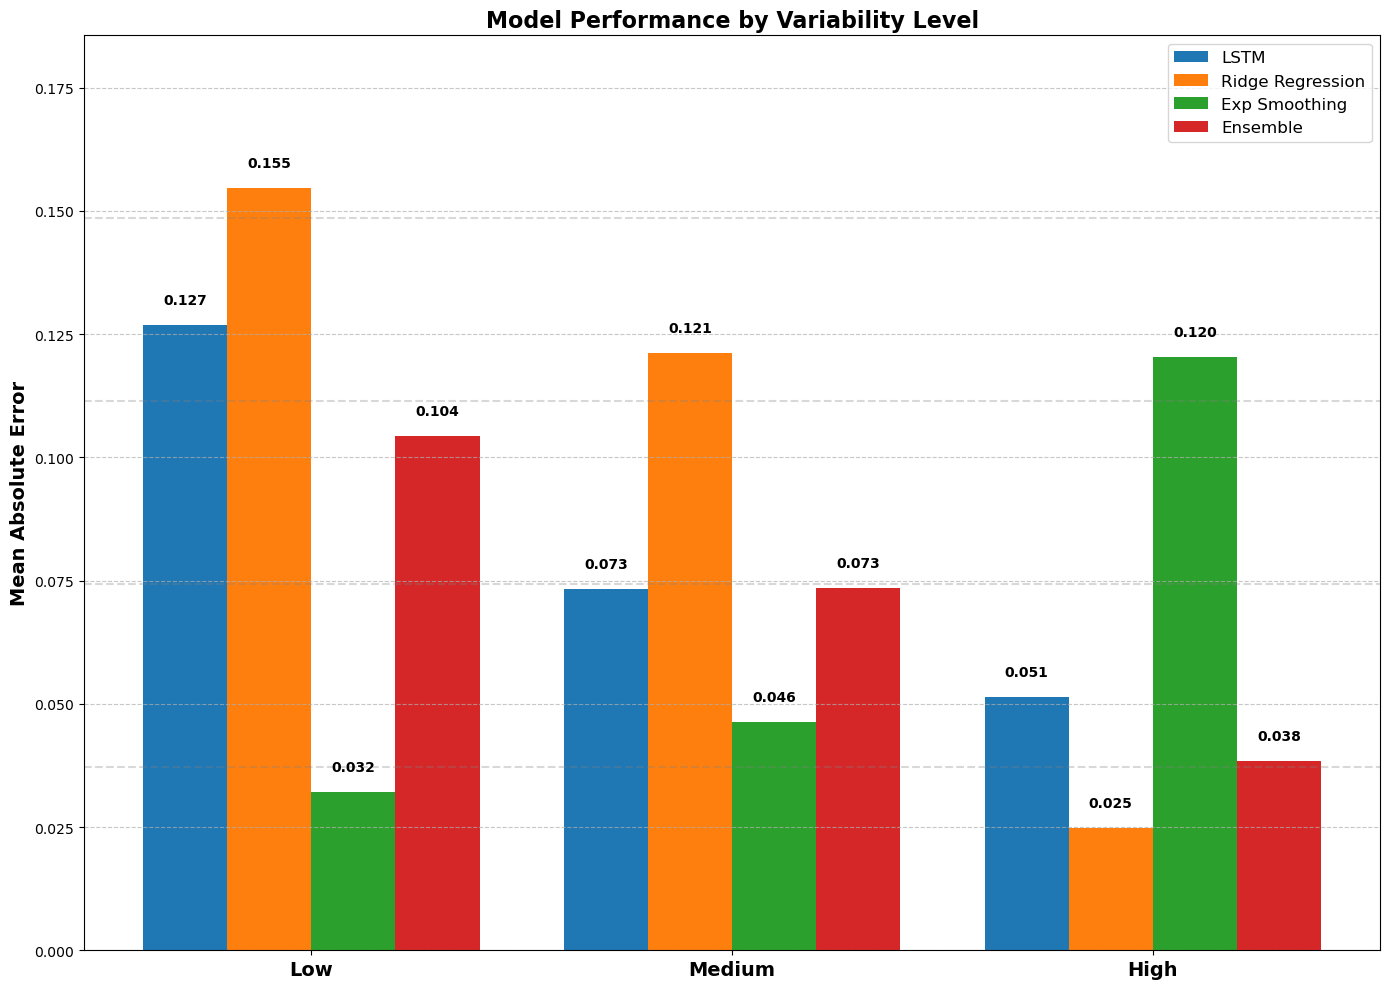

Zoomed MAE comparison plot saved to ./results/mae_comparison_zoomed_20250509_180736.png


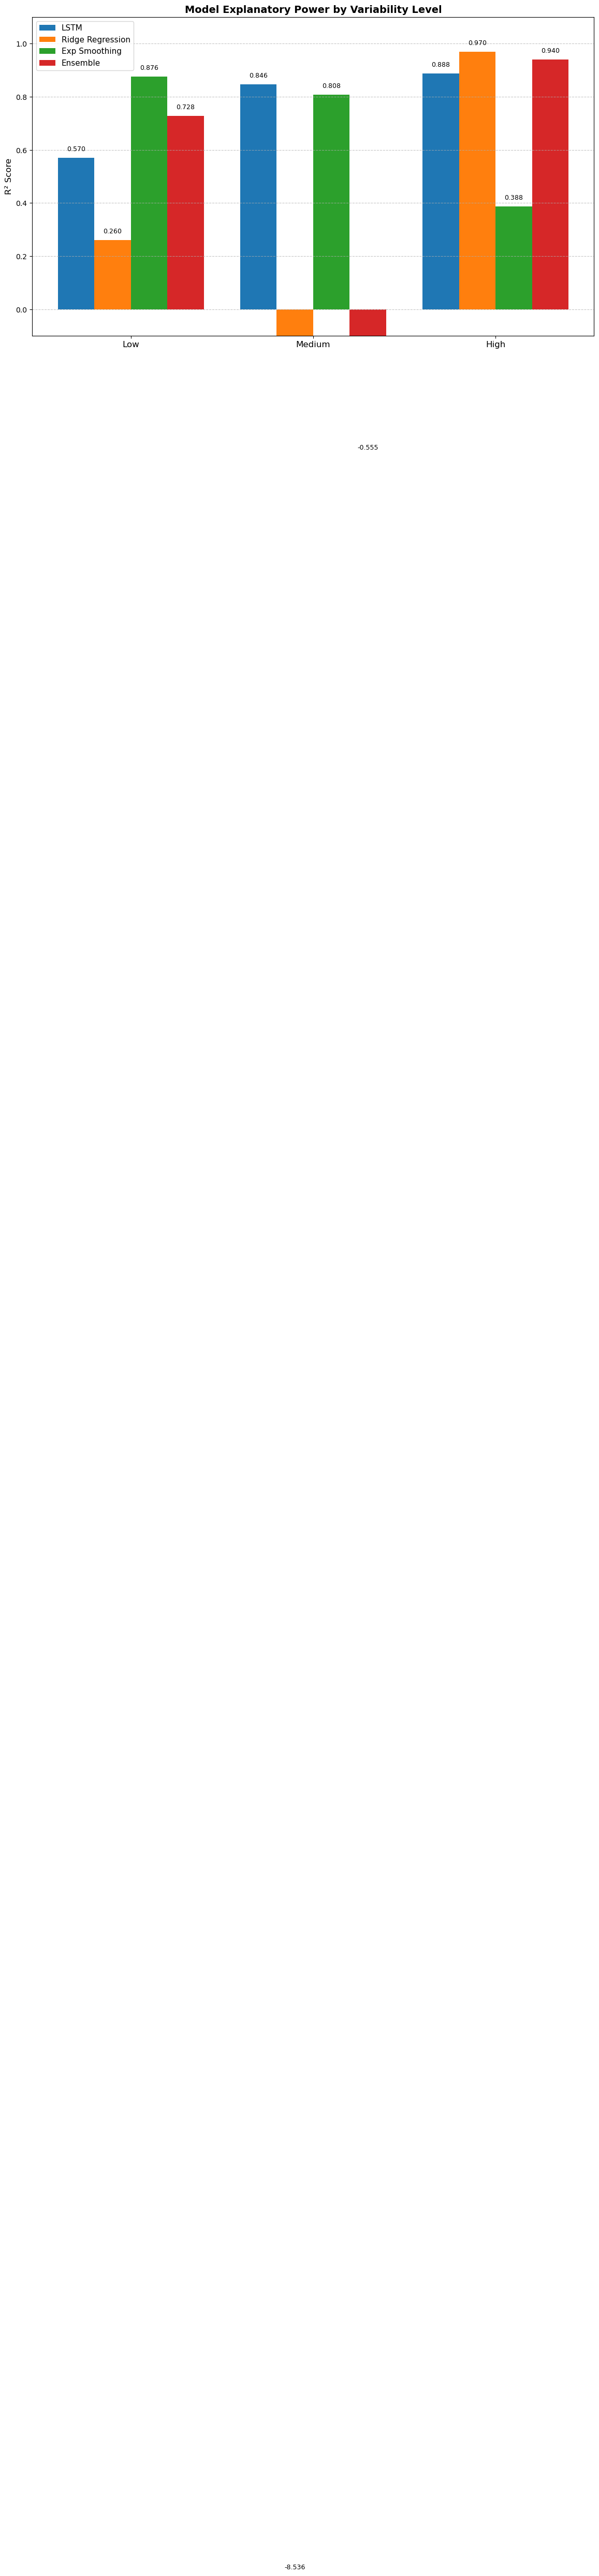

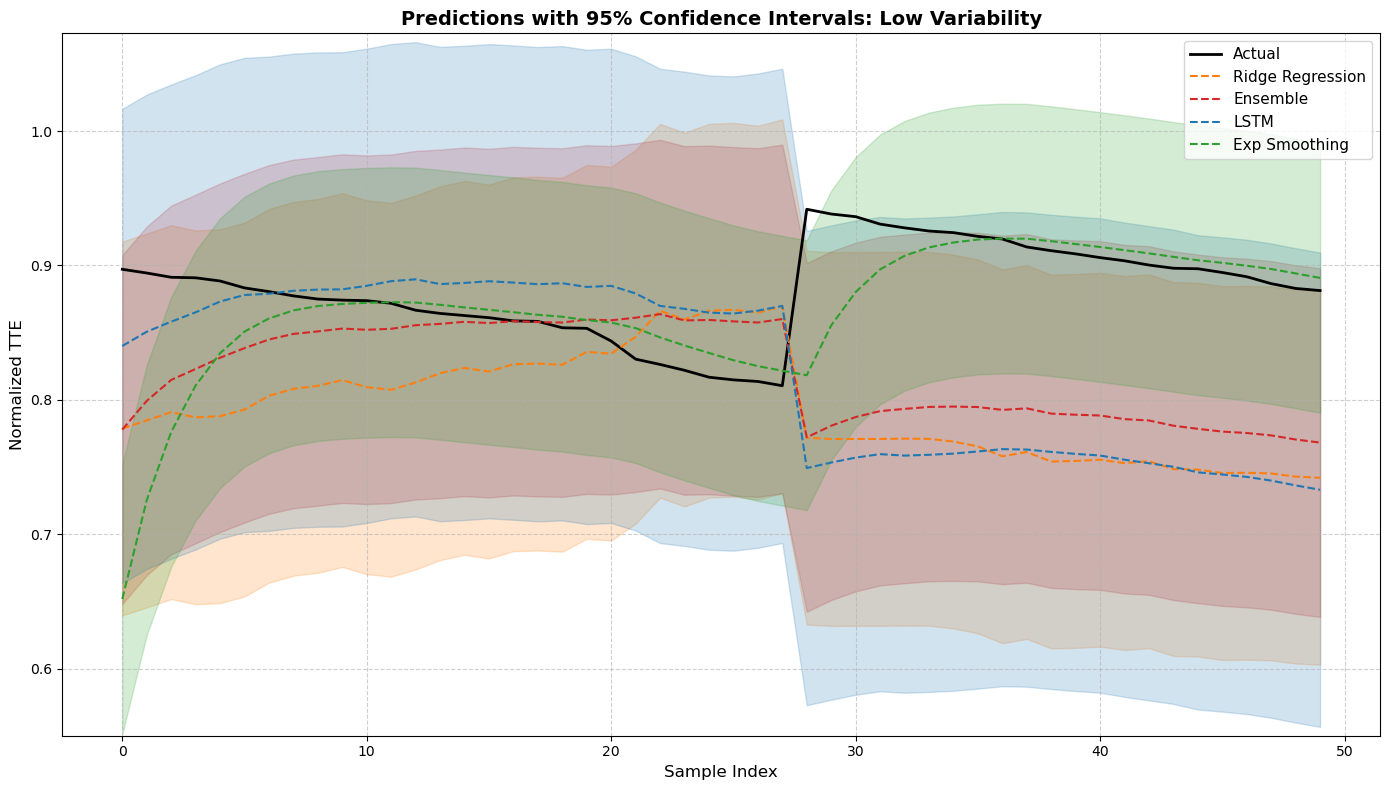

No prediction data available for error plot in low scenario


<Figure size 1400x800 with 0 Axes>

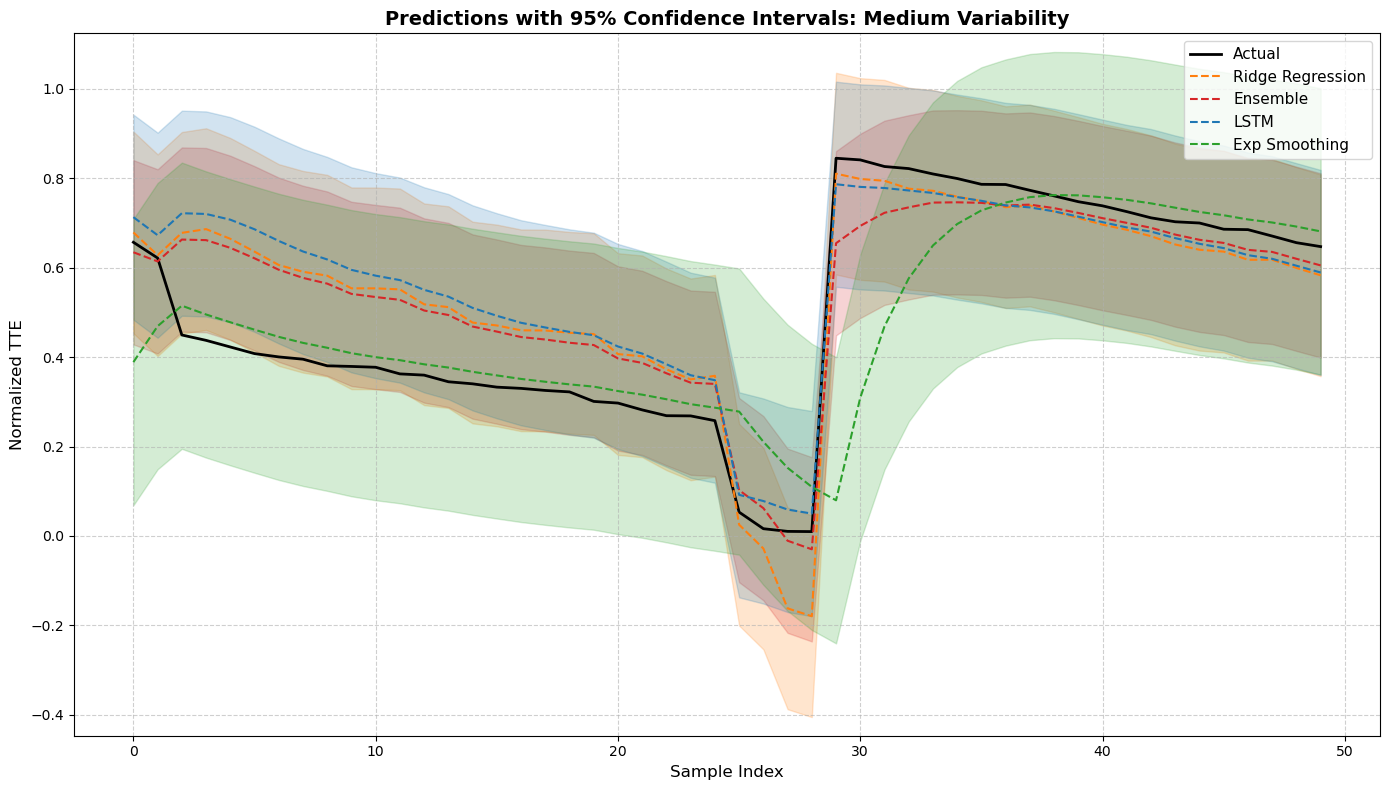

No prediction data available for error plot in medium scenario


<Figure size 1400x800 with 0 Axes>

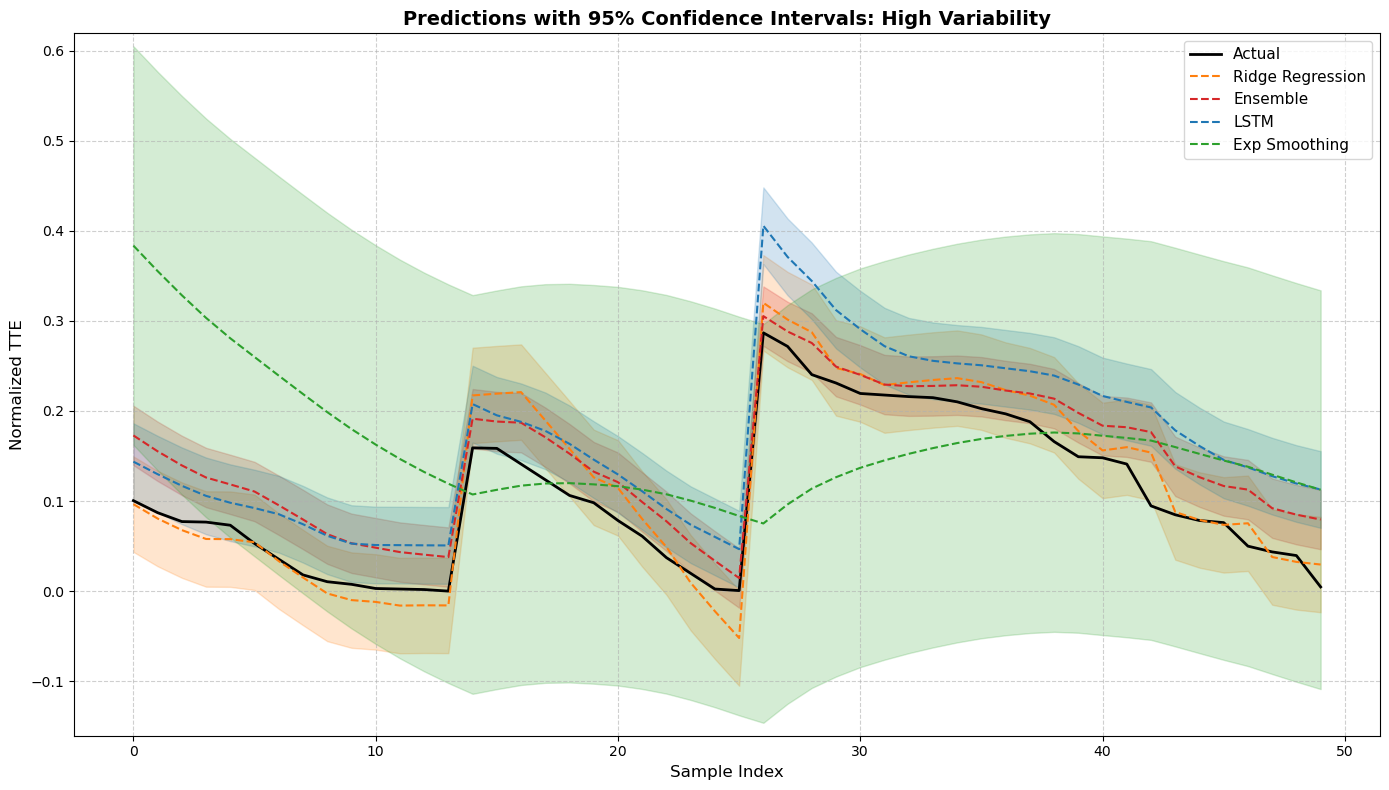

No prediction data available for error plot in high scenario


<Figure size 1400x800 with 0 Axes>

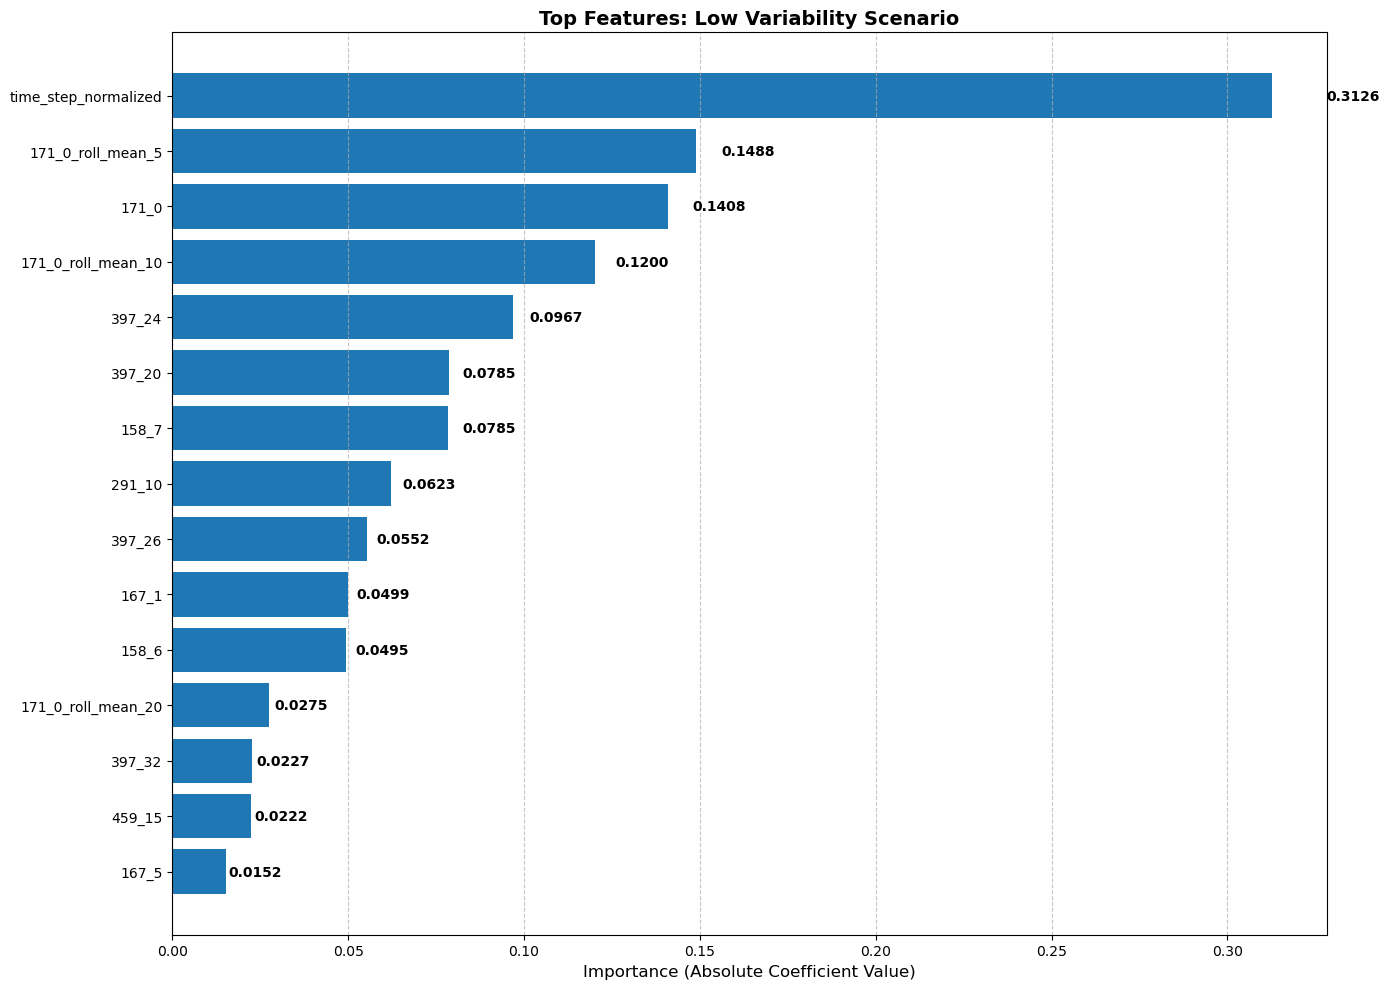

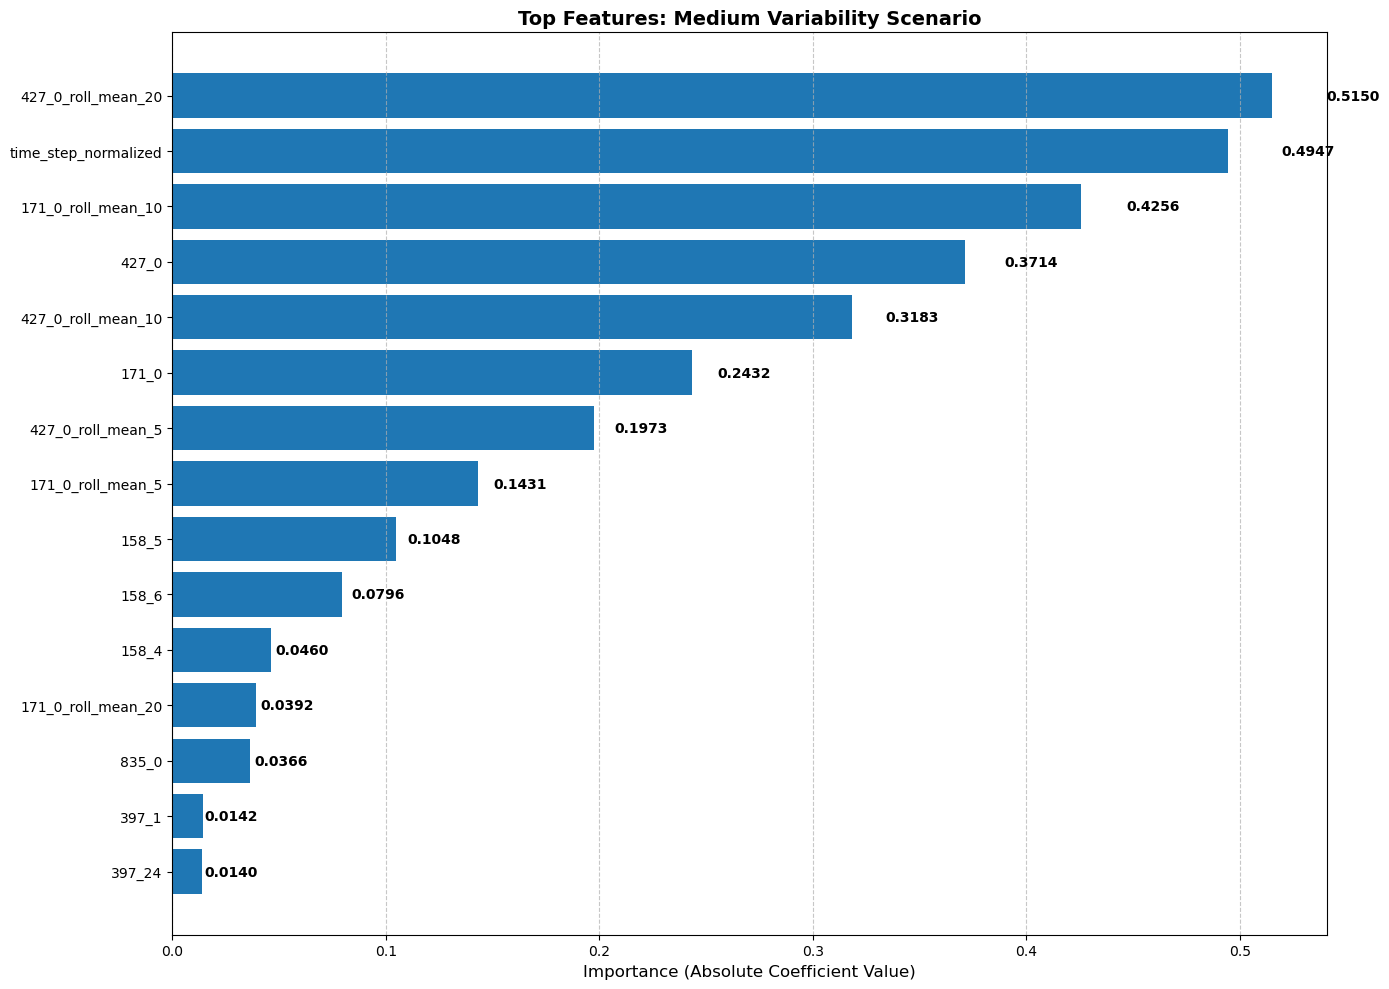

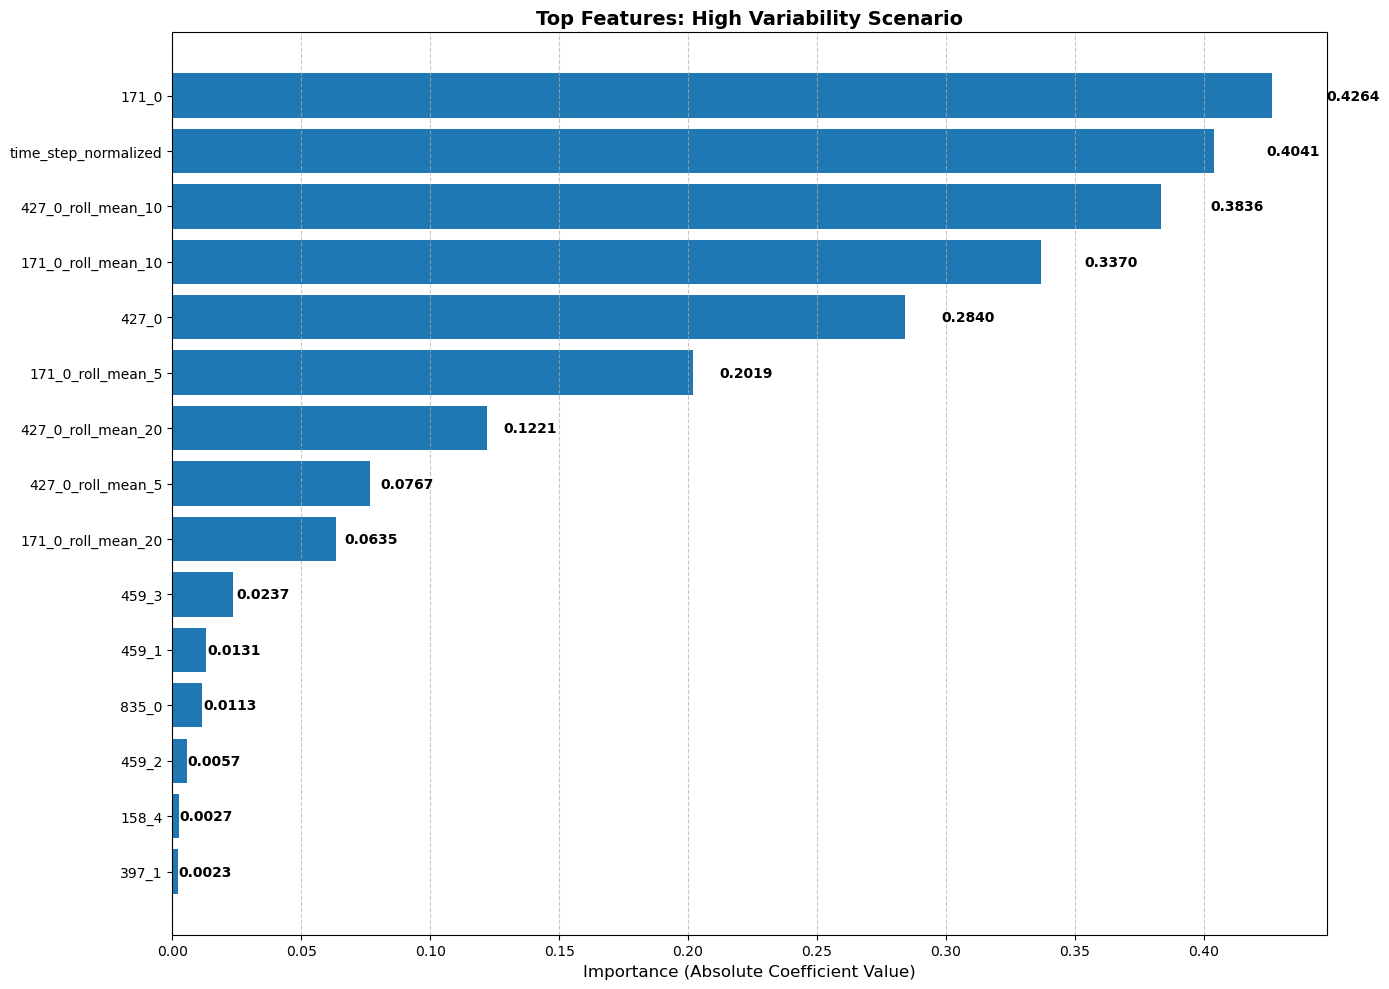


Performance Summary:
Scenario  LSTM MAE  LSTM R²  Ridge MAE  Ridge R²   ES MAE    ES R²  Ensemble MAE  Ensemble R²
     Low  0.126812 0.569709   0.154691  0.260234 0.032016 0.875681      0.104258     0.728045
  Medium  0.073205 0.846099   0.121147 -8.535544 0.046316 0.808058      0.073402    -0.554613
    High  0.051413 0.888125   0.024803  0.969821 0.120273 0.387681      0.038304     0.940051
Performance summary saved to ./results/performance_summary_20250509_180736.csv

--- MODEL SELECTION GUIDELINES ---

For Low Variability Scenario:
  Recommended Model: Exponential Smoothing
  MAE: 0.0320

For Medium Variability Scenario:
  Recommended Model: Exponential Smoothing
  MAE: 0.0463

For High Variability Scenario:
  Recommended Model: Ridge Regression
  MAE: 0.0248
  Top 3 Predictive Features:
    - 171_0: 0.4264
    - time_step_normalized: 0.4041
    - 427_0_roll_mean_10: 0.3836
Saved comparison table to ./metrics_20250509_180736/model_comparison_report/model_comparison_table.csv
Save

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found becau

Saved radar chart to ./metrics_20250509_180736/model_comparison_report/radar_chart.png

Comprehensive report generated in ./metrics_20250509_180736/model_comparison_report


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

Missing required metrics: ['Memory_increase']


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 


===== RESOURCE USAGE SUMMARY =====

total_execution:
  Duration: 207.1369 seconds
  Memory increase: 409.30 MB
  Final memory: 1692.15 MB

data_loading_preprocessing:
  Duration: 2.1762 seconds
  Memory increase: -18.52 MB
  Final memory: 1264.32 MB

cleaning_preprocessing:
  Duration: 31.1007 seconds
  Memory increase: 125.79 MB
  Final memory: 1390.12 MB

feature_engineering_preprocessing:
  Duration: 3.8856 seconds
  Memory increase: 0.00 MB
  Final memory: 1390.12 MB

Analysis complete.
Results saved to: ./results
Metrics saved to: ./metrics_20250509_180736
Paper figures saved to: ./paper_figures_20250509_180736
Paper summary generated: tte_prediction_paper_findings.md


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

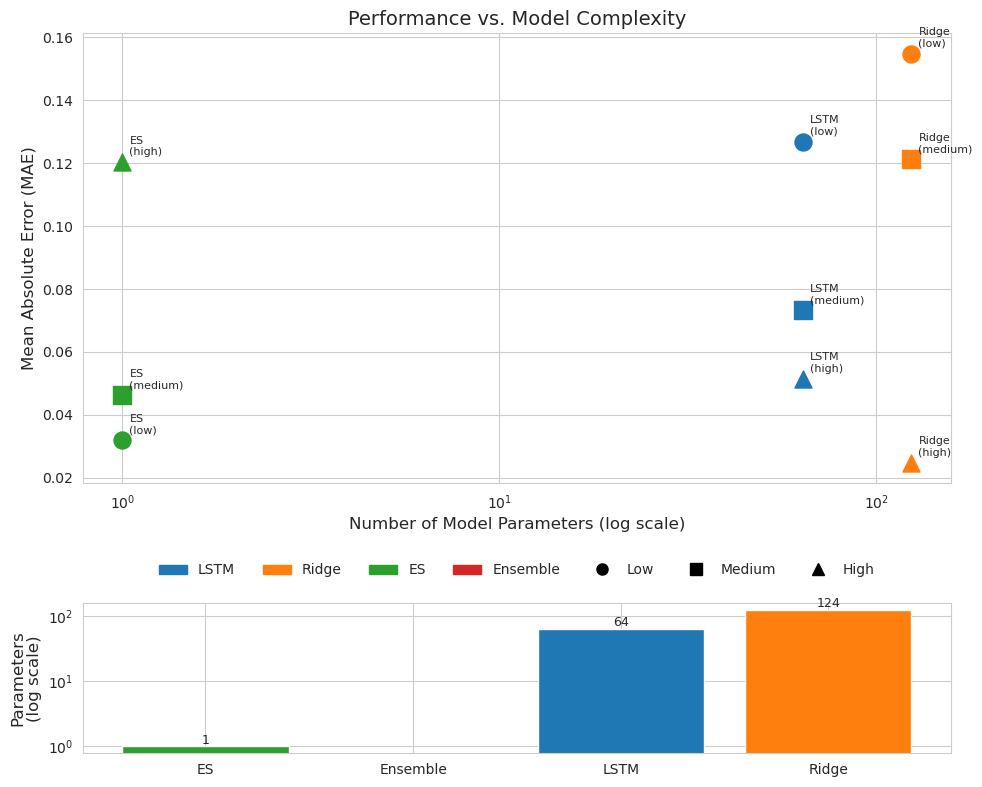

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

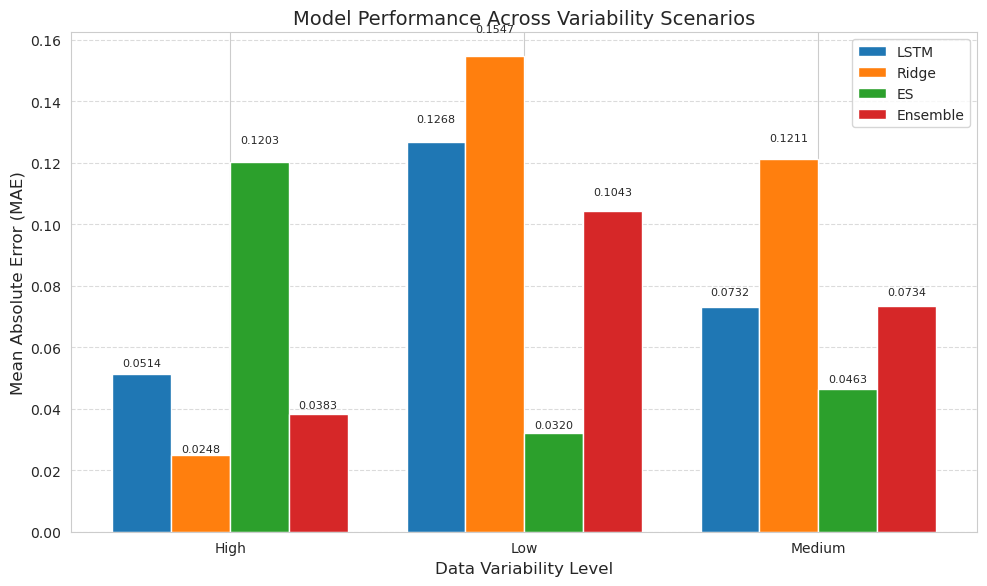

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

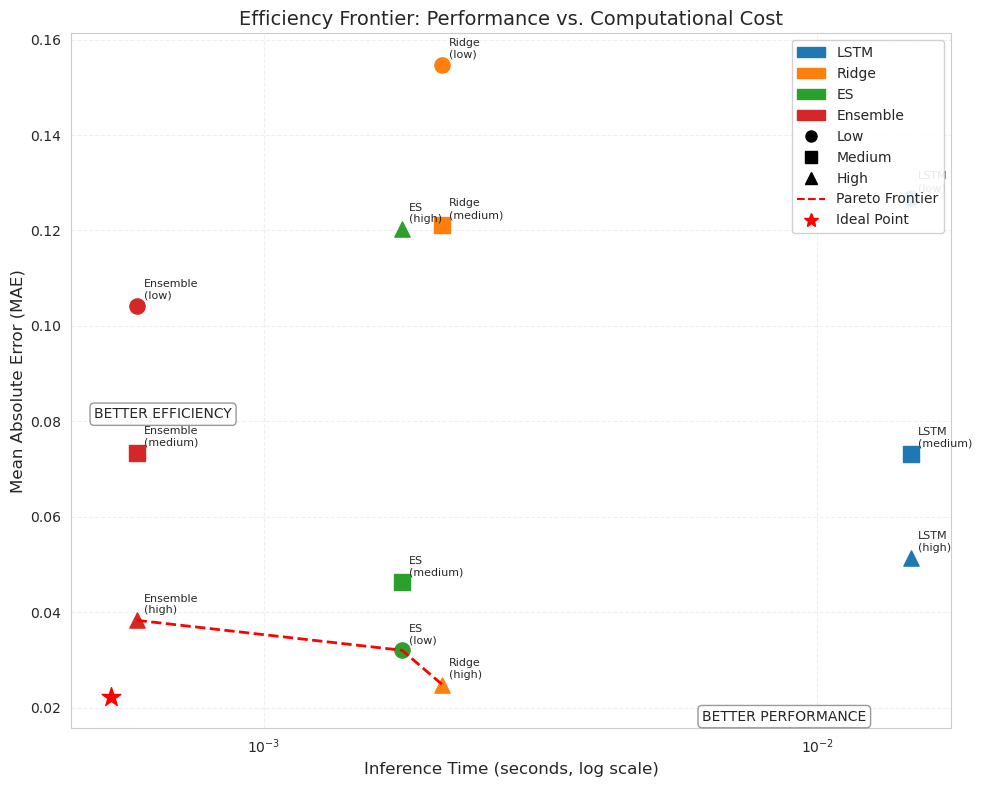

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

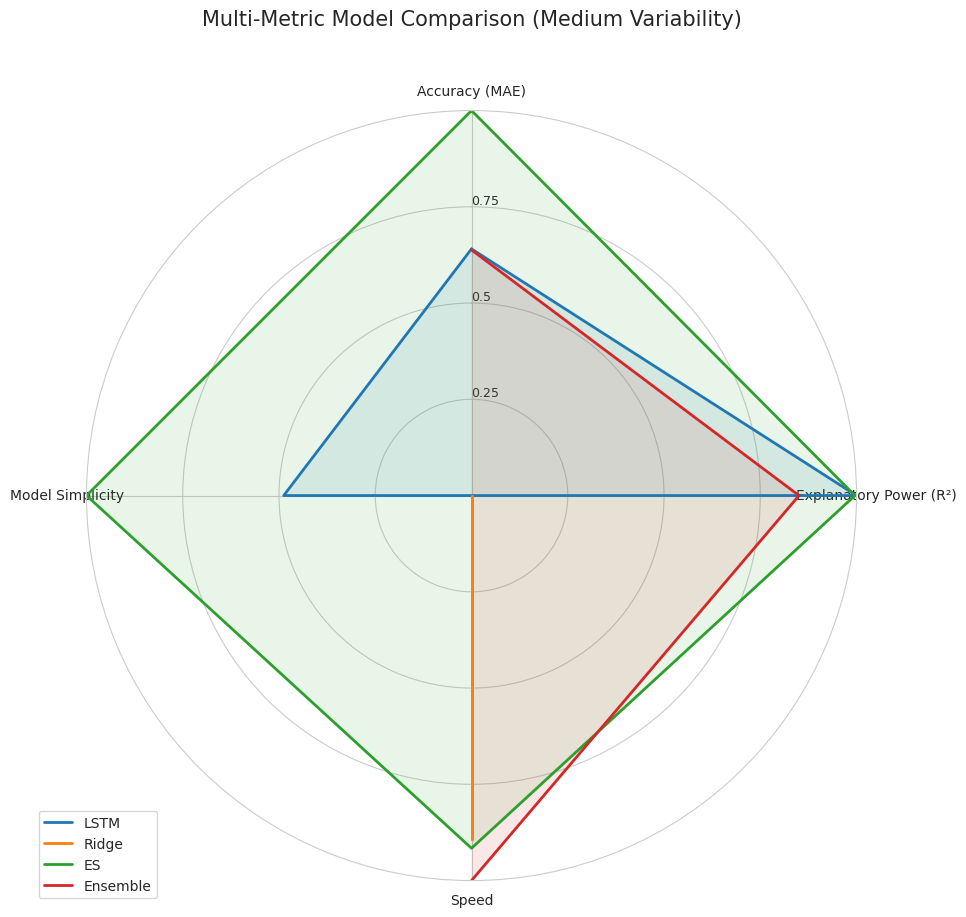

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

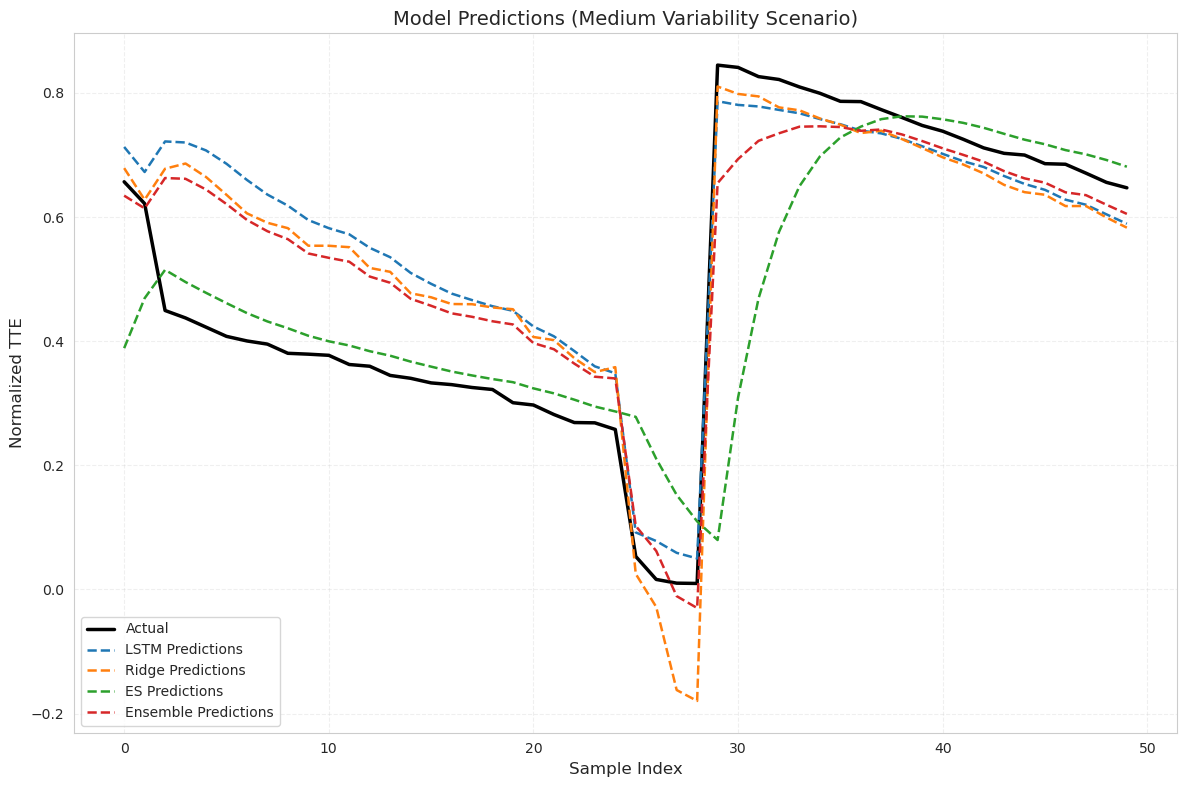

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

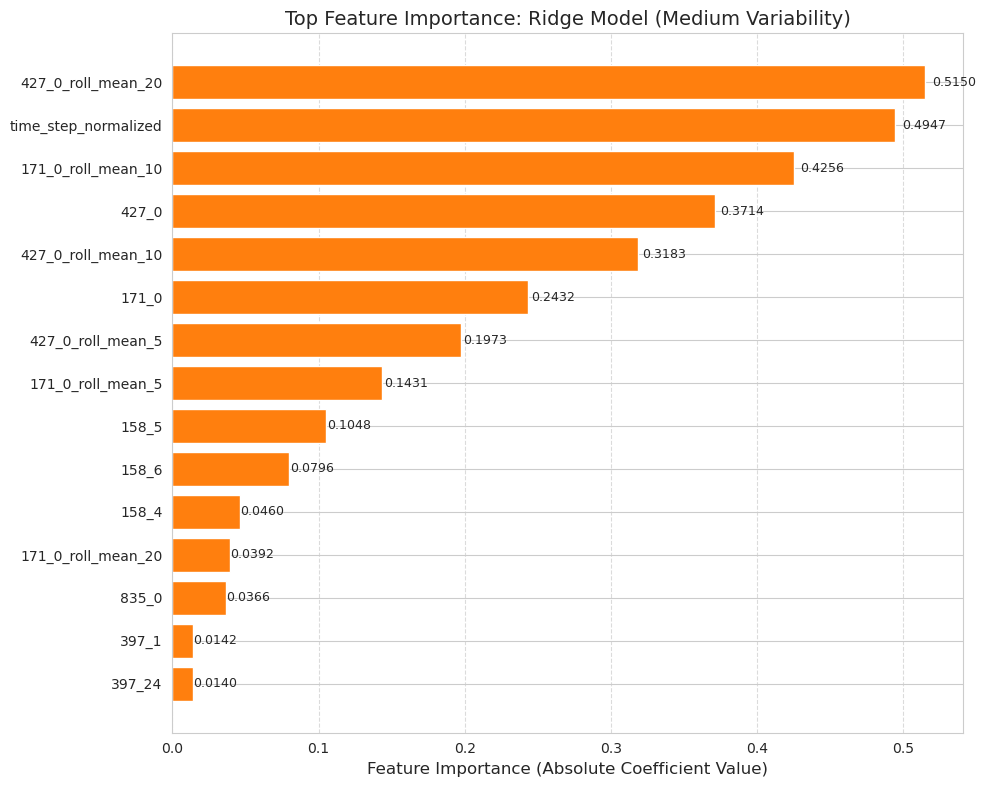

In [7]:
# Run the enhanced pipeline
predictor, model_comparison, figures = run_tte_prediction_with_metrics(
    './2241data/train_operational_readouts.csv',
    './2241data/train_tte.csv',
    config_path=None  # Or provide a path to your config file
)

# Generate paper summary
from integration_example import generate_paper_summary
summary_file = generate_paper_summary(predictor, "tte_prediction_paper_findings.md")